In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erfc
from scipy.signal import convolve
%matplotlib inline

pi = np.pi

plt.rcParams['font.size'] = 40
plt.rcParams['figure.figsize'] = (40, 10)
plt.rcParams['lines.linewidth'] = 2.0

## Globale Konstanten

In [2]:
delta_t = 1/1000
T_s = 1

# Fuer "lange" Signale
t = np.r_[-3*T_s:6*T_s+delta_t:delta_t]

# Fuer Filterimpulsantworten
t_short = np.r_[-2*T_s:2*T_s+delta_t:delta_t]

## Kleine Funktionsbibliothek für das Zeichnen von Signalen

### Impulssequenz für Sendesymbolfolgen

In [3]:
def plot_impulse_sequence(k, d_k, x_label=r'$t/T_\mathrm{s}$', y_label=r'$d(t)$'):
    plt.figure()
    plt.axhline(c='k', lw=2, alpha=0.75)
    plt.plot(k[d_k >  0], d_k[d_k >  0], 'b^', ms=30)
    plt.plot(k[d_k <  0], d_k[d_k <  0], 'bv', ms=30)
    plt.plot(k[d_k == 0], d_k[d_k == 0], 'bo', ms=15)
    plt.vlines(k, 0, d_k, 'b', lw=4)
    plt.axvline(c='k', lw=2, alpha=0.75)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim((min(d_k)-0.1, max(d_k)+0.1))
    plt.xlim( ( np.floor(min(t)), np.ceil(max(t)) ) )
    plt.grid(True)

### Allgemeines Signal

In [4]:
def plot_signal(t, signal, T_s=1, delta_t=1/1000, 
                x_label=r'$t/T_\mathrm{s}$', y_label='$x(t)$',
                x_lim=(-1, 5)):
    plt.figure()
    plt.axhline(c='k', lw=2, alpha=0.75)
    plt.plot(t, signal, 'b', lw=4)
    plt.axvline(c='k', lw=2, alpha=0.75)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim((min(signal)-0.1, max(signal)+0.1))
    plt.xlim(x_lim)
    plt.grid(True)

### Einzeichnen von Abtastwerten

In [5]:
def plot_samples(t, signal, T_s=T_s, delta_t=delta_t):
    samp_per_period = int(T_s/delta_t)
    low = int(np.round(t[0]/delta_t))
    upp = int(np.round(t[-1]/delta_t))+1
    
    samp_idx = np.r_[low:upp:samp_per_period]
    samp_val = signal[0:len(t)+1:samp_per_period]
    
    plt.plot(delta_t*samp_idx, samp_val, 'ro', ms=20)
    plt.vlines(delta_t*samp_idx, 0, samp_val, 'r', lw=4)

### Sendepulse

In [6]:
def plot_pulse(t, signal, T_s=1,
               x_label=r'$t/T_\mathrm{s}$', y_label='$x(t)$'):
    x_lim=(-2, 2)
    plot_signal(**locals())

### Gesamtpulse
Einzeichnen der Werte zu Vielfachen der Abtastperiodendauer für das Nyquistkriterium

In [7]:
def plot_complete_pulse(t, signal, T_s=T_s,
                        x_label=r'$t/T_\mathrm{s}$', y_label='$x(t)$'):
    plot_pulse(**locals())
    plot_samples(t, signal, T_s)

### Entscheidungssignale
Einzeichnen der Abtastwerte

In [8]:
def plot_decision_signal(t, signal, T_s=T_s,
                x_label=r'$t/T_\mathrm{s}$', y_label='$x(t)$',
                x_lim=(-1, 5)):
    plot_signal(**locals())
    plot_samples(t, signal, T_s, delta_t)

### Augendiagramme

In [9]:
def plot_eye_diagram(q_t, t=t, T_s=T_s, delta_t=delta_t, 
                     t_start=0, t_end=5*T_s,
                     x_lim=(-1, 1),
                     x_label=r'$t/T\mathrm{s}$',
                     y_label=r'$q(t)$'):
    t_start = t[0] if t_start is None else t_start
    t_end = t[-1] if t_end is None else t_end
    
    K = int((t_end - t_start)/T_s)
    t_interval = np.r_[-T_s:T_s:delta_t]
        
    plt.figure()
    plt.axhline(c='k', lw=1, alpha=0.75)
    for k in range(1, K):
        current_idx = ( (t_start + (k-1)*T_s <= t)
                       *(t <= t_start + (k+1)*T_s))
        q_current = q_t[current_idx]
        q_samp = q_current[int(len(q_current)/2)]
        plt.plot(t_interval[:len(q_current)], q_current, 
                 'b', lw=3, alpha=0.8)
        plt.plot(0, q_samp, 'ro', ms=10)
    
    plt.axvline(c='k', lw=1, alpha=0.75)
    
    plt.xlim(x_lim)
    y_bound = 1.05*max(abs(q_t.max()), abs(q_t.min()))
    plt.ylim(-y_bound, y_bound)
    
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.gcf().set_size_inches((5, 5))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.grid(True)

### Filterung mit  Impulsantwort eines LTI-Systems

In [10]:
def lti_filter(x, h, delta_t=delta_t):
    if len(x) < len(h):
        x, h = h, x
    return convolve(x, h, mode='same')*delta_t

### Nützliche Pulsformen

In [11]:
def tri(t, T):
    return (1-np.abs(t/T))*(np.abs(t) < T) if T > 0 else t*0

In [12]:
def rect(t, T):
    return (np.abs(t) < T/2)*1.0

# Aufgabe 14: Zeitdiskrete Zufallsprozesse

## Vorbemerkungen

### Erklärung der Konventionen:
Die Filter sind immer folgendermaßen bezeichnet:
- **Sendefilter** $\quad g(t) \quad$
- **Kanalfilter** $\quad b(t) \quad$
- **Empfangsfilter** $\quad f(t) \quad$
- Die Faltung $\quad g(t) \ast b(t) = h(t) \quad $ ist später wichtig für die Bestimmung von $f(t)$ (siehe Matched Filter)
- Die Faltung $\quad g(t) \ast b(t) \ast f(t) = h(t) \ast f(t) \quad = \quad p(t)  \quad$ heißt **Gesamtfilter** und ist **Die wichtige Größe beim 1. Nyquistkriterium**.

Die vorkommenden Signale sind:
- **Sendesymbolfolge**: $\quad A(k) \quad$ mit kontinuierlicher Darstellung   
    $\quad A(t) = \sum_{k = -\infty}^{\infty}A(k) \delta(t - kT_\mathrm{s})$
- **Sendesignal** (Send Signal):   
    $\quad s(t) = A(t) \ast g(t) \qquad = \qquad \sum_{k = -\infty}^{\infty}A(k) g(t - kT_\mathrm{s})$
- **Empfangssignal** (Receive Signal):   
    $\quad r(t) = s(t) \ast b(t) + n(t) \qquad = \qquad \sum_{k = -\infty}^{\infty}A(k) h(t - kT_\mathrm{s}) + n(t)$
- **Entscheidungssignal** (Quantization Signal) vor dem Abtaster:   
    $\quad q(t)= r(t) \ast f(t) \qquad = \qquad \sum_{k = -\infty}^{\infty}A(k) p(t - kT_\mathrm{s}) + n(t) \ast f(t)$
- **Entscheidungssignal** (Quantization Signal) nach dem Abtaster:   
    $q(k) = \left.q(t)\right|_{t= m T_\mathrm{s}} \qquad = \qquad \sum_{k = -\infty}^{\infty} A(k) p((m - k)T_\mathrm{s}) + n'(k T_\mathrm{s})$

## Aufgabenstellung
Gegeben sei das nachfolgend dargestellte PAM-Übertragungssystem:

![Blockdiagramm](figures/A14/System_Blockdiagramm.png)

Die Eingangssymbols $A(k)$ seien aus dem Alphabet $A(k) \in \{{-}1, 1\}$ und sind weiß. Die Symbolrate sei $1/T_\mathrm{s} = 10\,\mathrm{Baud}$. Der Kanal sei mit $b(t) = \delta(t)$ ideal. Für die Sende- und Empfangsfilter stehen folgende Paare zur Auswahl:
- $$g_{1}(t) = \mathrm{rect}\left(\frac{t}{T_\mathrm{s}}\right), \qquad f_1(t) = \frac{1}{T_\mathrm{s}} \mathrm{rect}\left( \frac{2\,t}{T_\mathrm{s}} \right)$$
- $$g_2(t) = \mathrm{rect}\left(\frac{2\,t}{3\,T_\mathrm{s}}\right), \qquad f_2(t) = \frac{1}{T_\mathrm{s}} \mathrm{rect}\left( \frac{t}{T_\mathrm{s}} \right)$$
- $$g_3(t) = \Lambda\left(\frac{t}{T_\mathrm{s}}\right), \qquad f_3(t) = \delta(t)$$

Es sei nun die Symbolfolge $A(k) = [{-}1, {-}1, 1, {-}1, 1]$ gegeben.

In [13]:
# Padding, damit genug Raum fuer Faltungen bleibt
A_k = np.array([0, 0, 0, 0 , -1, -1, 1, -1, 1, 0, 0])

# Kontinuierliche Darstellung als gewichtete Dirac-Impulsfolge
A_t = np.zeros_like(t)
A_t[t % T_s < 0.001] = A_k/delta_t

#### Symbolfolge im Kontinuierlichen

\begin{align}
    A(t) = \sum_{k = -\infty}^{\infty} A(k)\delta(t -k T_\mathrm{s})
\end{align}

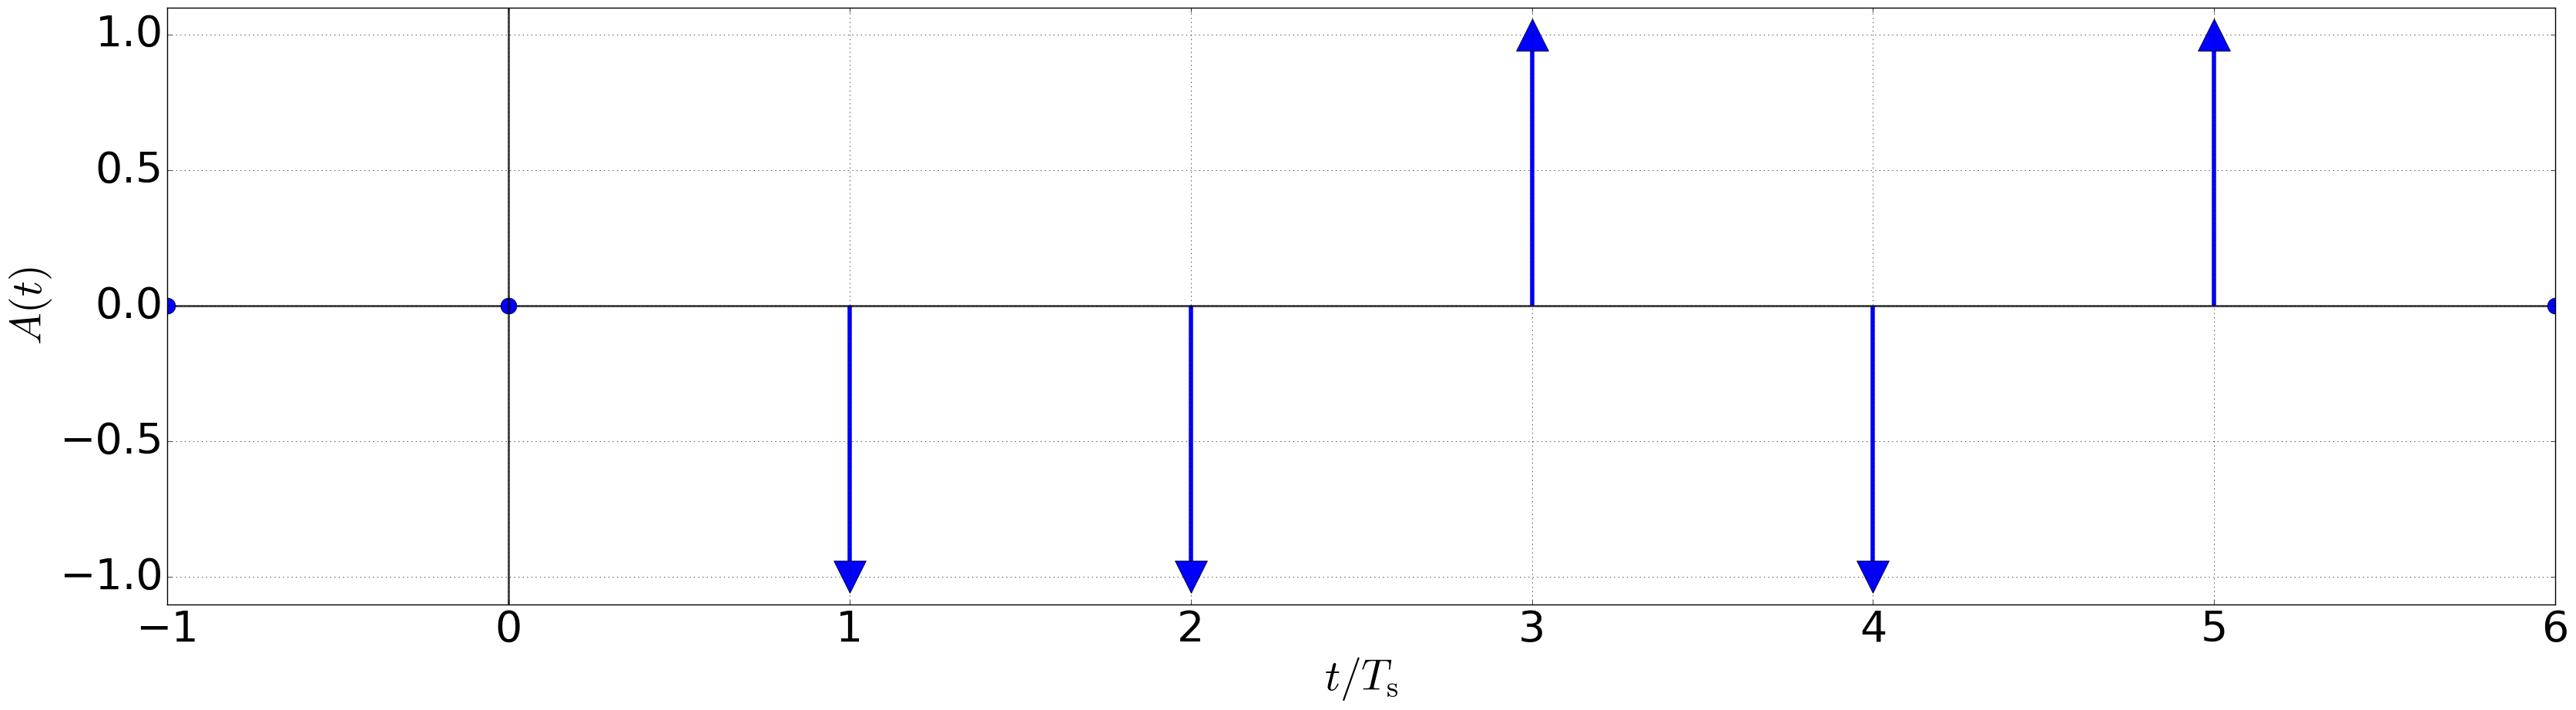

In [14]:
k_disc = -3 + np.arange(len(A_k))
plot_impulse_sequence(k_disc, A_k, y_label=r'$A(t)$')
plt.xlim((-1, 6));

## 14.1:
Skizzieren sie den Verlauf des Signals $s_i(t)$ für alle 3 Fälle

Formel:

\begin{align}
    s_i(t) = \sum_{k = -\infty}^{\infty}A(k) g_i(t - kT_\mathrm{s})
\end{align}

Rezept:
- Symbolfolge $A(k)$ als Impulssequenz plotten
- um jeden Impuls die Sendepulsform einzeichnen

#### Fall $i=1$:

\begin{align}
    g_1(t) = \mathrm{rect}\left( \frac{t}{T_\mathrm{s}} \right)
\end{align}

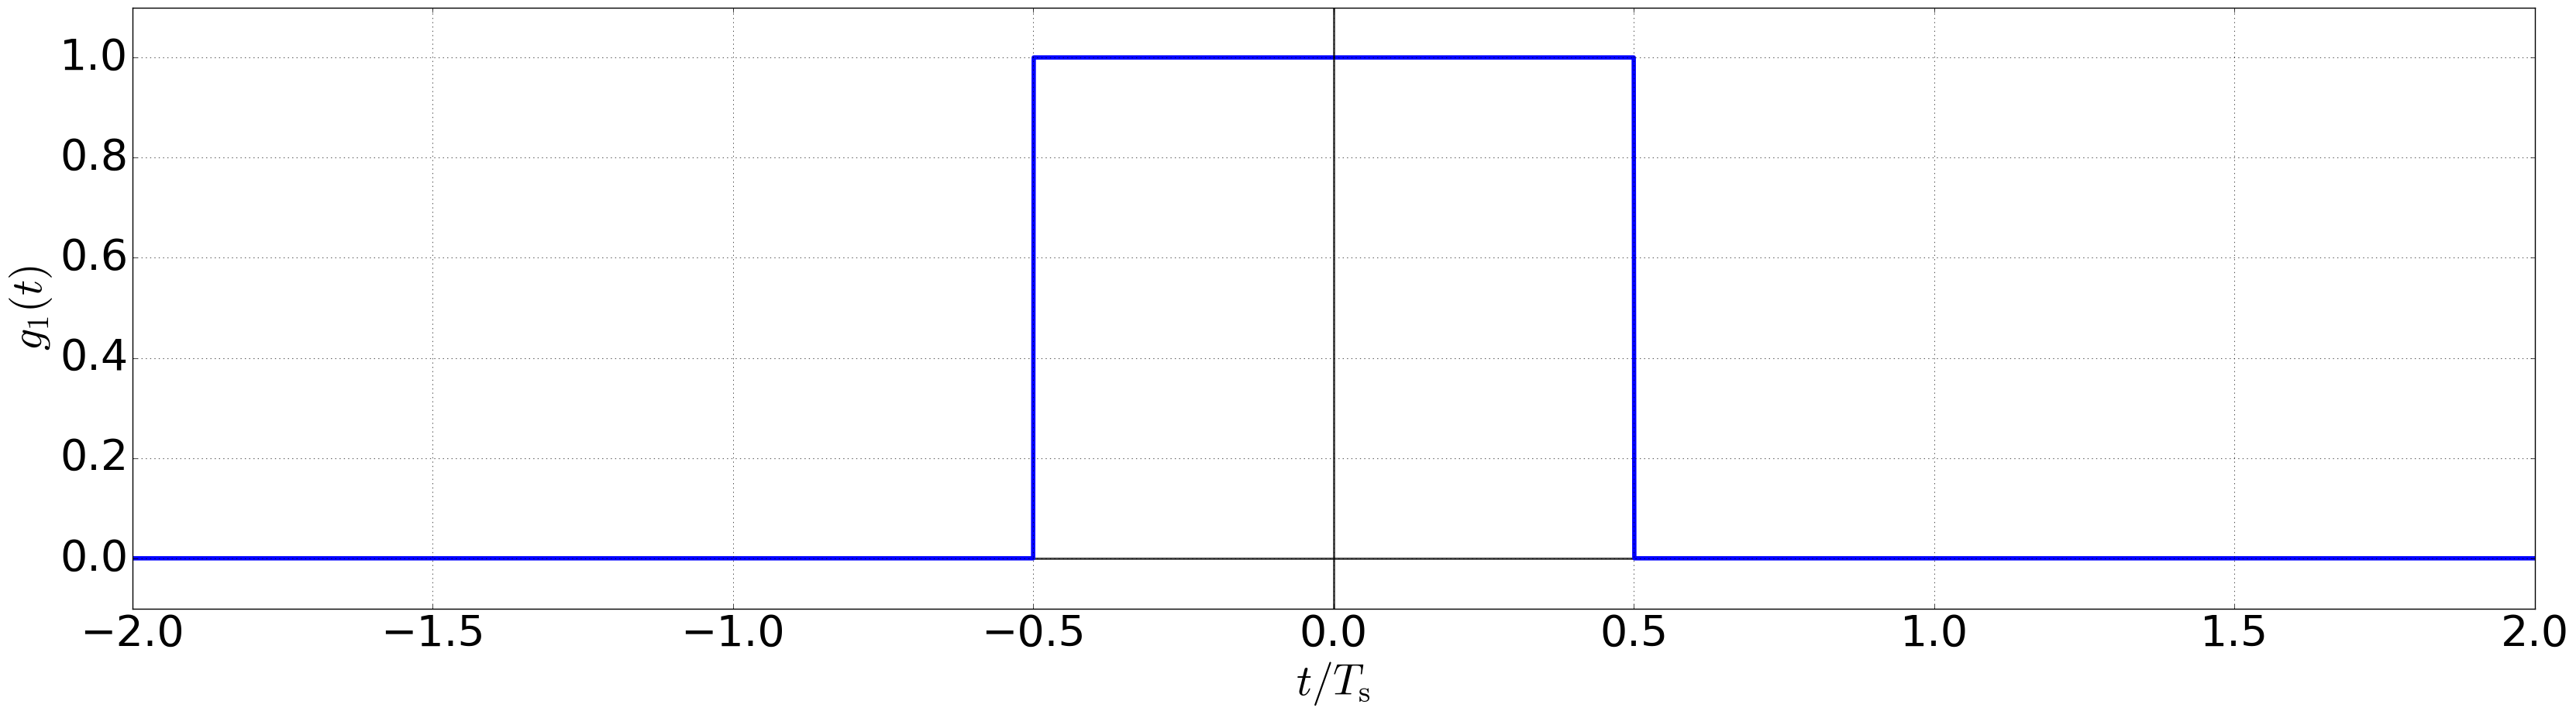

In [15]:
g_1_t = rect(t_short, T_s)
plot_pulse(t_short, g_1_t, y_label=r'$g_1(t)$')

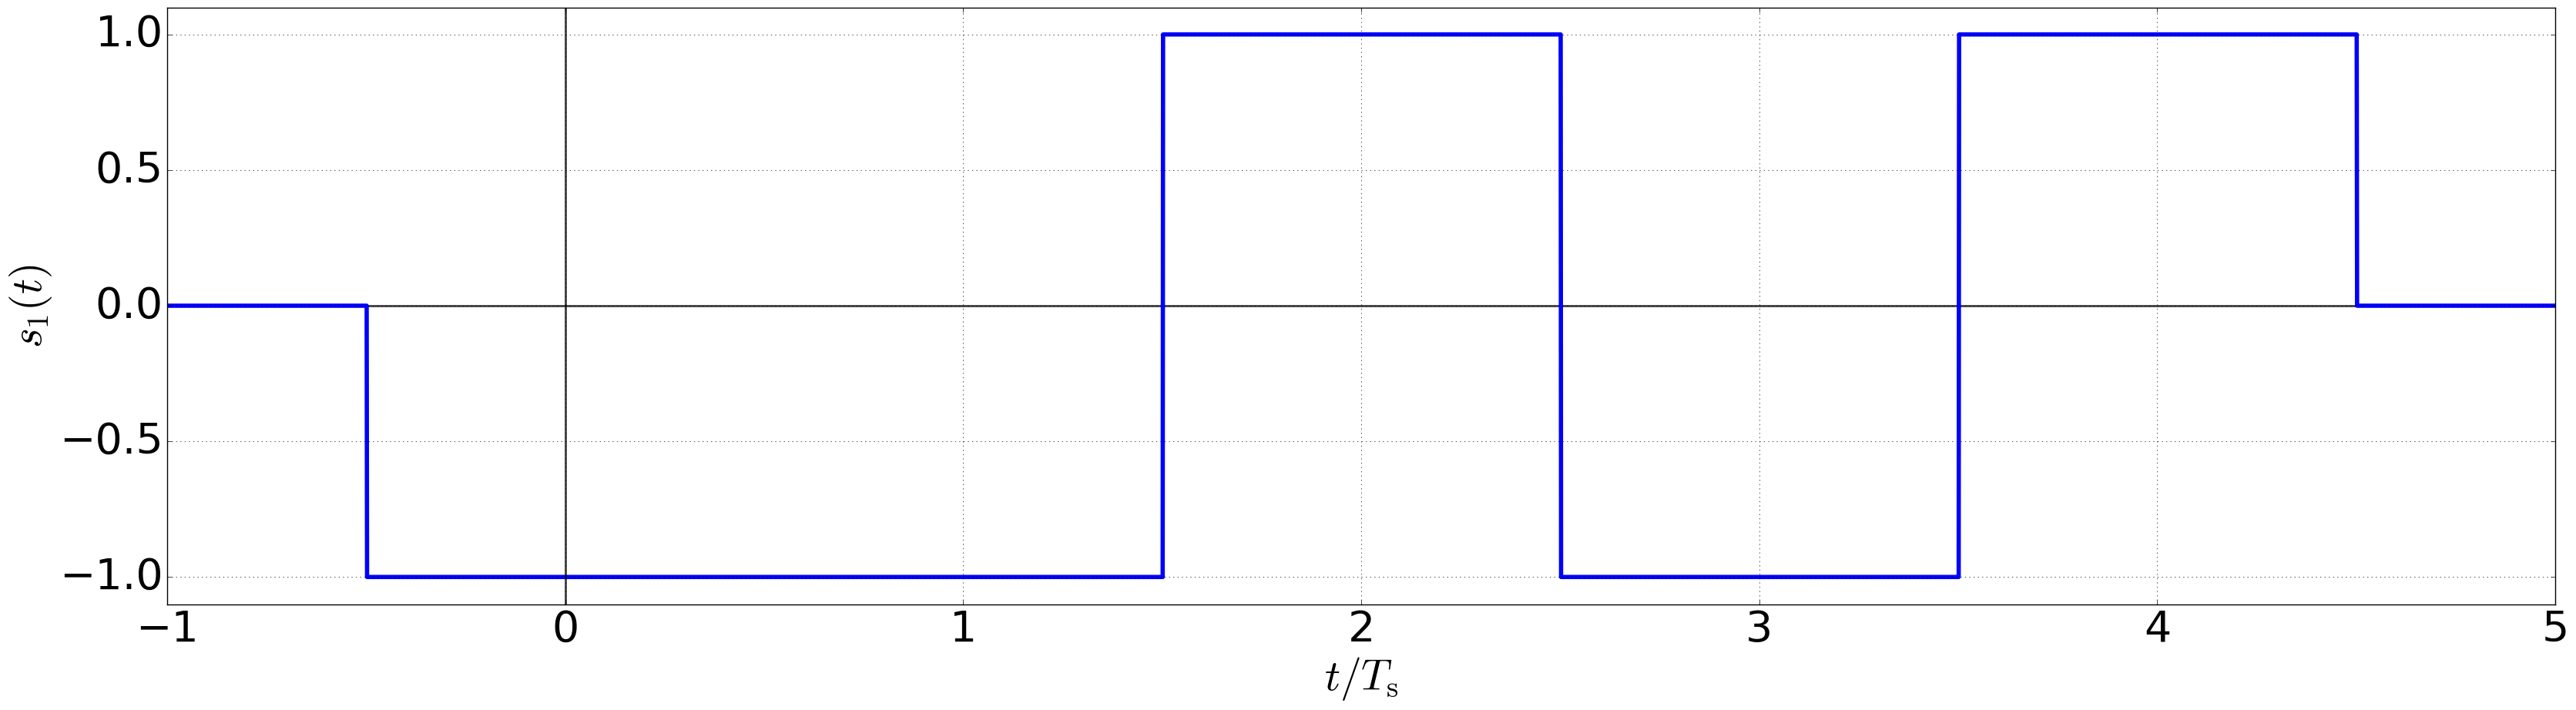

In [16]:
s_1_t = lti_filter(A_t, g_1_t)
plot_signal(t, s_1_t, y_label=r'$s_1(t)$')

#### Fall $i=2$:

\begin{align}
    g_2(t) = \mathrm{rect}\left( \frac{t}{3/2\,T_\mathrm{s}} \right)
\end{align}

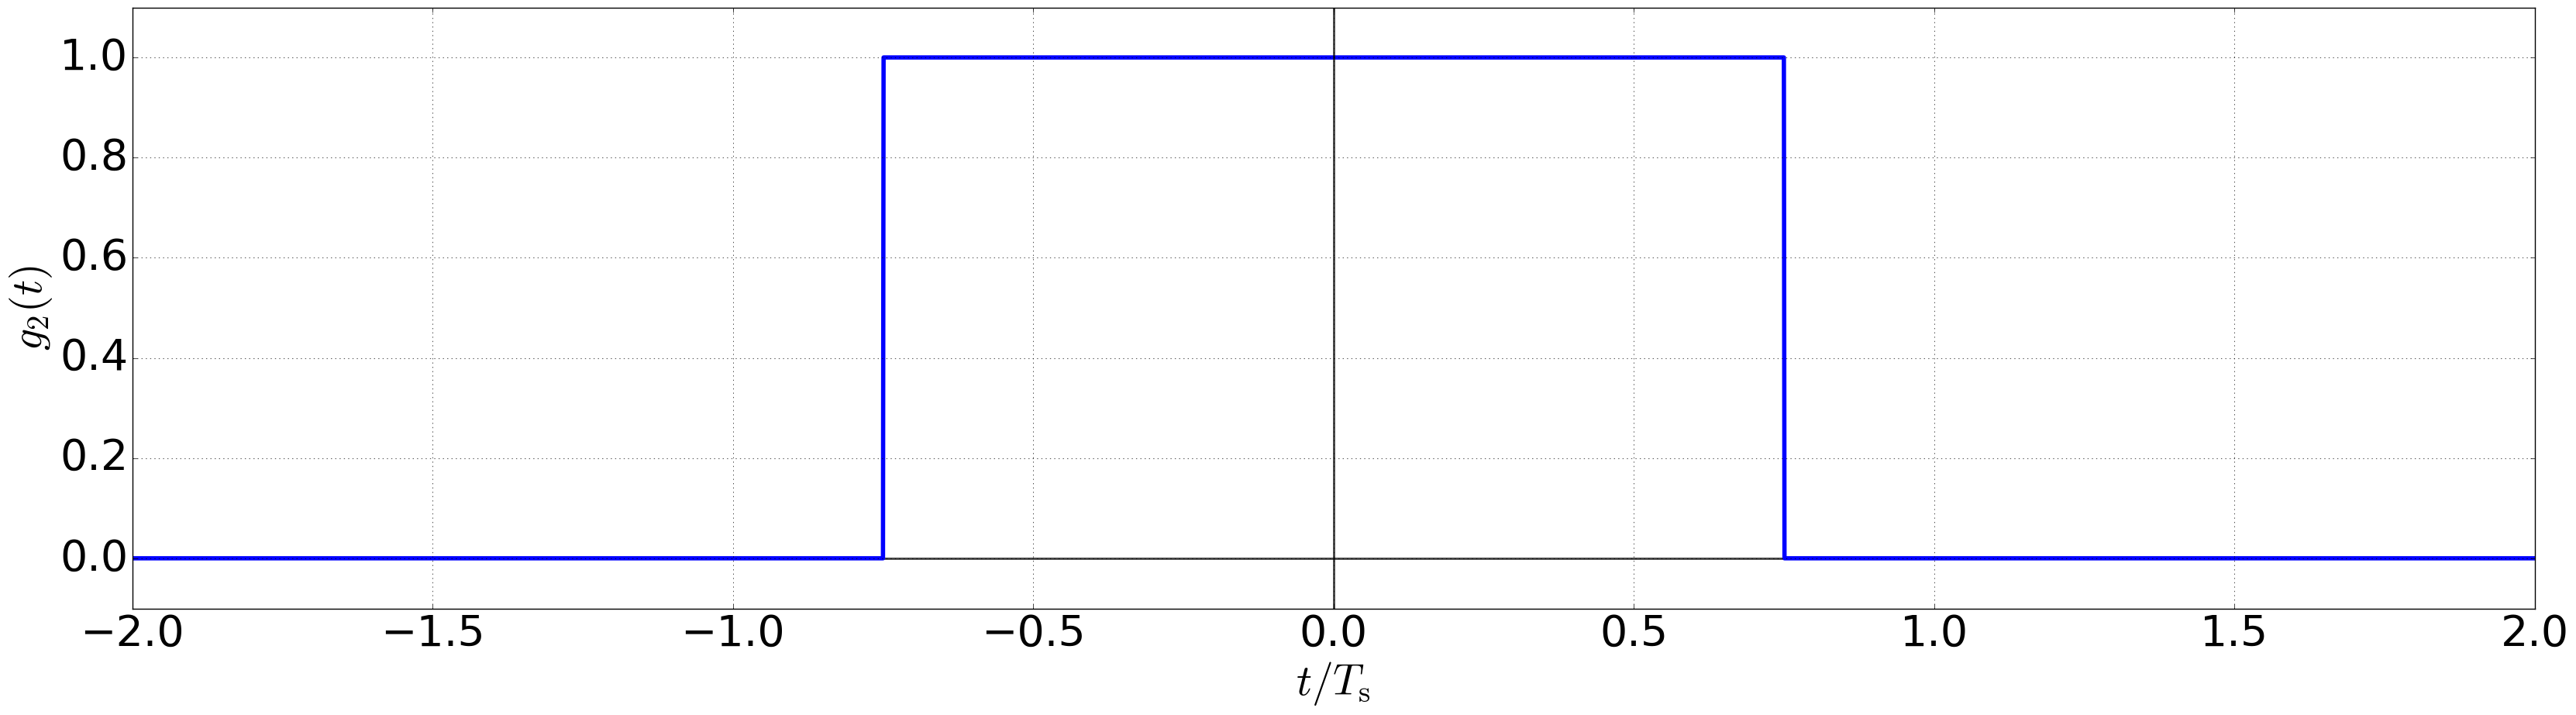

In [17]:
g_2_t = rect(t_short, 3/2*T_s)
plot_pulse(t_short, g_2_t, y_label=r'$g_2(t)$')

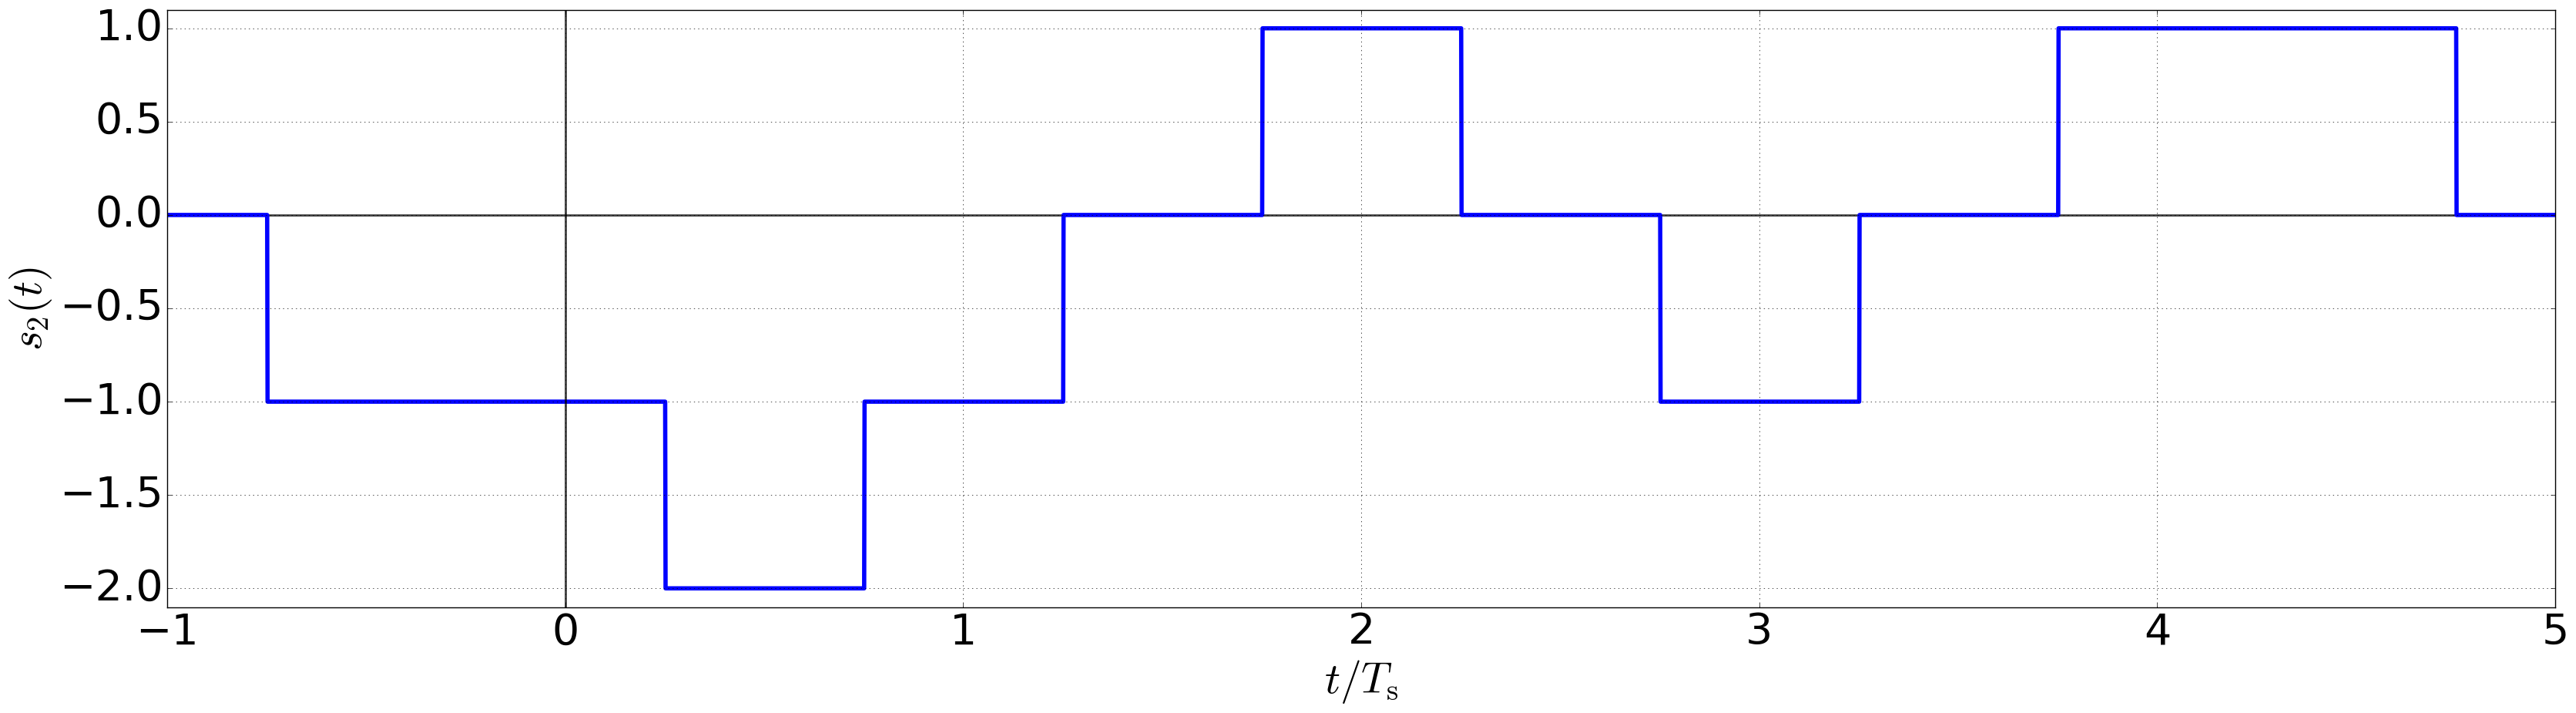

In [18]:
s_2_t = lti_filter(A_t, g_2_t)
plot_signal(t, s_2_t, y_label=r'$s_2(t)$')

#### Fall $i=3$:

\begin{align}
    g_3(t) = \Lambda \left( \frac{t}{T_\mathrm{s}} \right)
\end{align}

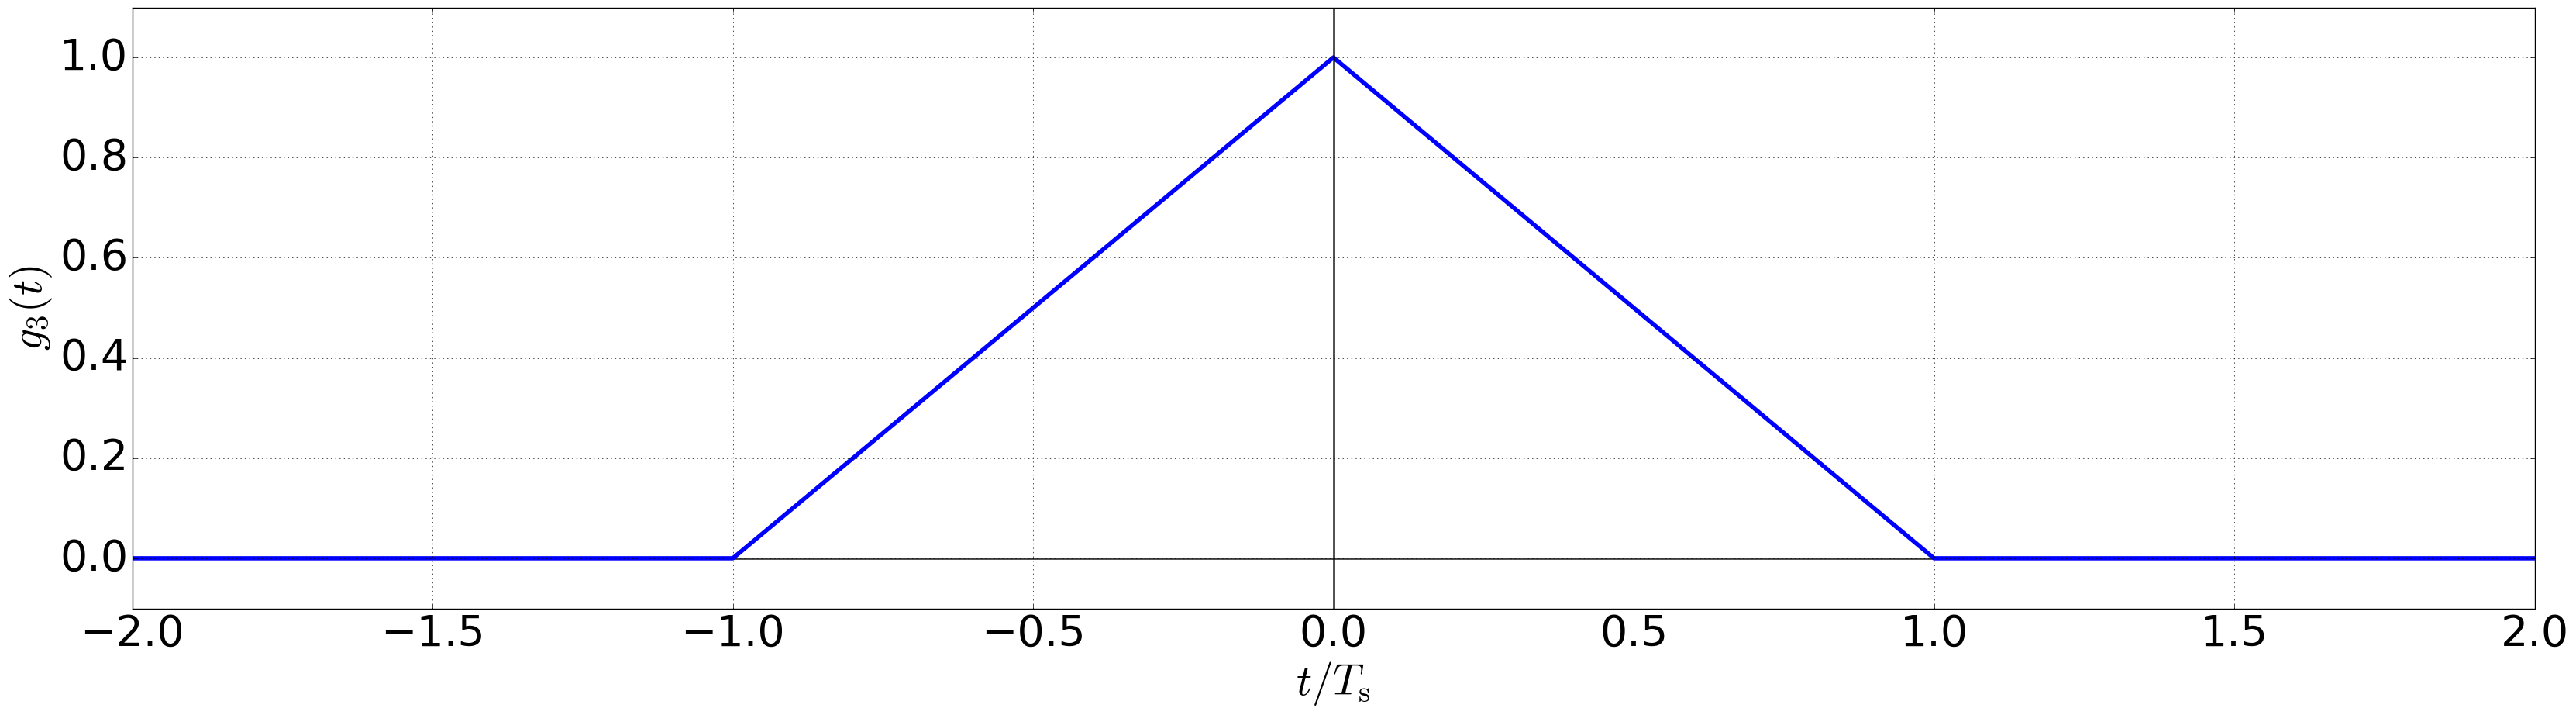

In [19]:
g_3_t = tri(t_short, T_s)
plot_pulse(t_short, g_3_t, y_label=r'$g_3(t)$')

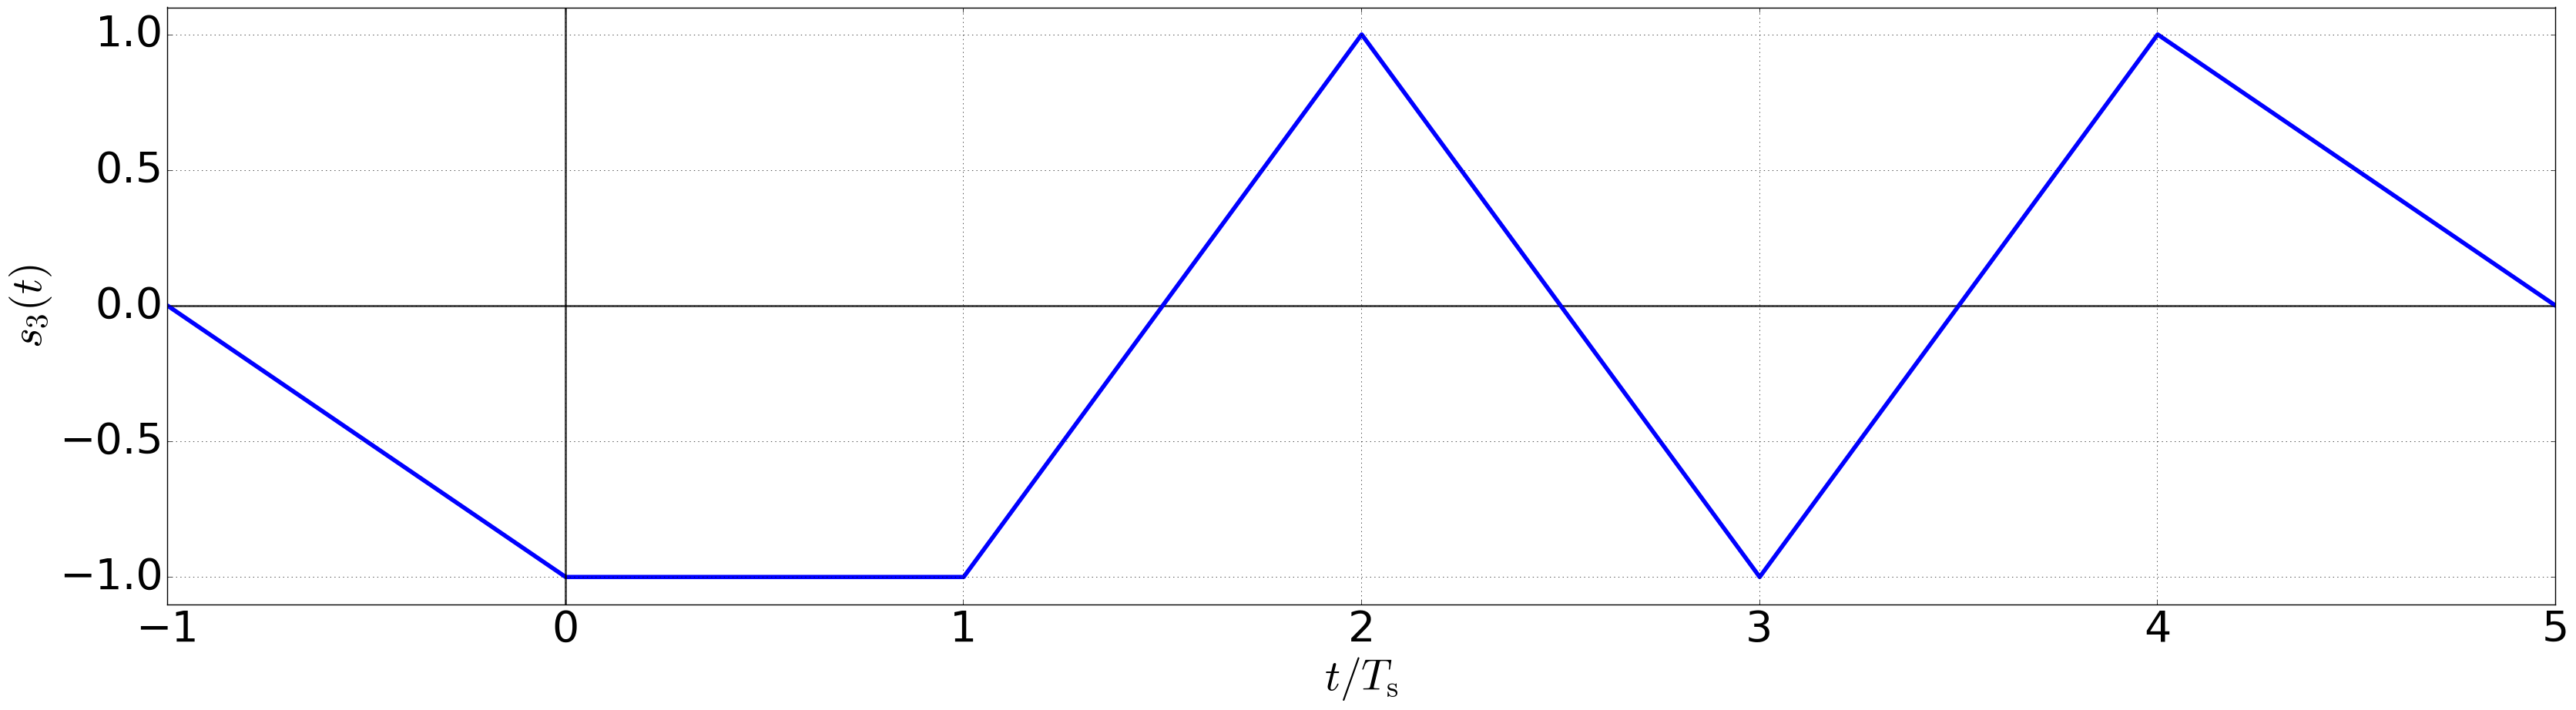

In [20]:
s_3_t = lti_filter(A_t, g_3_t)
plot_signal(t, s_3_t, y_label=r'$s_3(t)$')

## 14.2:
Für welches Paar ist die Übertragung frei von Intersymbolinterferenzen?

Die Frage bezieht sich darauf, welche der Paare von **Sende**- und **Empfangsfilter** das **erste Nyquistkriterium** erfüllen.

### Erstes Nyquistkriterium
**Damit keine Intersymbolinterferenzen auftreten, darf zum Zeitpunkt $m T_\mathrm{s}$ nur ein einziges Symbol den Abtastwert des Entscheidungssignals $q(k)$ beeinflussen**.

Das ist **für $n(t) = 0$** wegen

\begin{align}
    q(k) &= \sum_{k = -\infty}^{\infty} A(k) p((m - k)T_\mathrm{s}) \\
         &= A(m)p(0) + \sum_{k = -\infty, k \neq m}^{\infty} A(k) p((m - k)T_\mathrm{s})
\end{align}

im einfachsten Fall genau dann erfüllt, wenn **für das Gesamtfilter**

\begin{align}
    p(t) = g(t) \ast b(t) \ast f(t)
\end{align}

folgendes gilt:

\begin{align}
    p\left((m-k)T_\mathrm{s}\right) = C\cdot\gamma(m-k)
\end{align}

Denn genau dann sind alle Terme der Summe in der letzten Formel für $q(k)$ gleich Null und nur der Anteil von $A(m)$ bleibt übrig.
Wenn man zusätzlich eine beliebige Verschiebung um ganze Abtastwerte zulässt (das führt lediglich dazu, dass die Bitsequenz etwas später "ankommt"), ergibt sich das **erste Nyquistkriterium im Zeitbereich**:

\begin{align}
    p\left(k T_\mathrm{s}\right) = C\cdot\gamma(k - K)
\end{align}

Das Kriterium lässt sich am leichtesten überprüfen, indem $p(t)$ gezeichnet und an den Abtastzeitpunkten überprüft wird.

**Wichtig: Das Kriterium bezieht sich immer auf das Gesamtfilter!**    
  

Wie in der Erklärung angegeben, muss also **das Gesamtfilter** $p(t)$ überprüft werden. Dazu muss die Faltung der Teilfilter bestimmt werden. Wegen $b(t) = \delta(t)$, also einem verzerrungsfreien Kanal, müssen nur Sende- und Empfangsfilter betrachtet werden:

\begin{align}
    p(t) = g(t) \ast f(t)
\end{align}

#### Fall $i=1$:
Es wird der gleiche Trick wie in Übung 2 angewandt (Aufteilen des Rechtecks $g_1(t)$ in zwei Rechtecke der gleichen 
Größe wie $f_1(t)$:

\begin{align}
    p_1(t) &= g_1(t) \ast f_1(t) \\
     &= \mathrm{rect} \left( \frac{t}{T_\mathrm{s}} \right) \ast \frac{1}{T_\mathrm{s}} \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right) \\
     &= \left( \mathrm{rect} \left( \frac{t + T_\mathrm{s}/4}{T_\mathrm{s}/2} \right) + \mathrm{rect} \left( \frac{t - T_\mathrm{s}/4}{T_\mathrm{s}/2} \right) \right) \ast \frac{1}{T_\mathrm{s}} \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right) \\
     &= \frac{1}{2}\left( \Lambda \left( \frac{t + T_\mathrm{s}/4}{T_\mathrm{s}/2} \right) + \Lambda \left( \frac{t - T_\mathrm{s}/4}{T_\mathrm{s}/2} \right) \right)
\end{align}

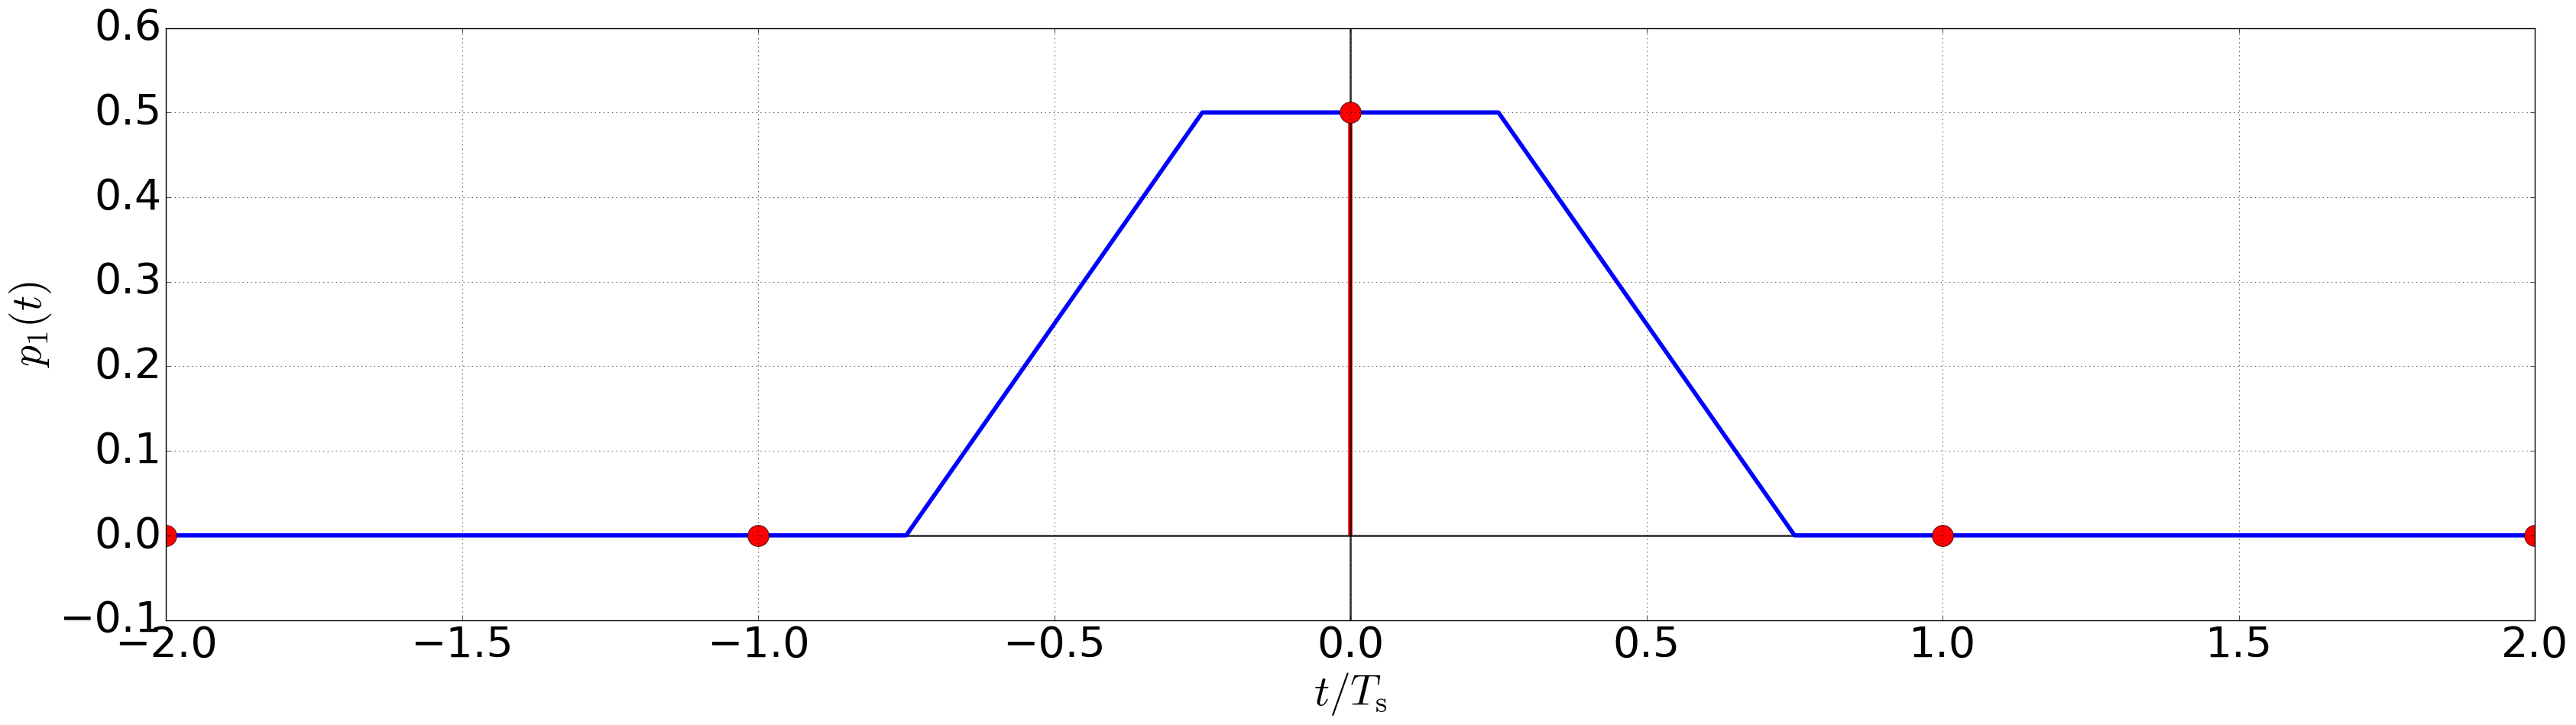

In [21]:
p_1_t = 1/2*( tri(t_short - T_s/4, T_s/2) + tri(t_short + T_s/4, T_s/2))
plot_complete_pulse(t_short, p_1_t, y_label=r'$p_1(t)$')

Wegen $p_1(k T_\mathrm{s}) = \frac{1}{2} \gamma(k)$ ist das erste Nyquistkriterium also erfüllt und die Übertragung ist ISI-frei.

#### Fall $i=2$:

Auch hier kann der Trick angewandt werden. Dieses Mal muss das Sende in drei Teilrechtecke und das Empfangsfilter in zwei Teilrechtecke der Breite $T\mathrm{s}/4$ zerlegt werden:

\begin{align}
    p_2(t) &= g_2(t) \ast f_2(t) \\
        &= \mathrm{rect} \left( \frac{t}{3/2 \, T_\mathrm{s}} \right) \ast \frac{1}{T_\mathrm{s}} \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right) \\
        &= \left( \mathrm{rect} \left( \frac{t + T_\mathrm{s}/2}{T_\mathrm{s}/2} \right)  + \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right)  + \mathrm{rect} \left( \frac{t - T_\mathrm{s}/2}{T_\mathrm{s}/2} \right) \right) \ast \frac{1}{T_\mathrm{s}} \left( \mathrm{rect} \left( \frac{t + T_\mathrm{s}/4}{T_\mathrm{s}/2} \right)  + \mathrm{rect} \left( \frac{t - T_\mathrm{s}/4}{T_\mathrm{s}/2} \right) \right) \\
        &= \frac{1}{T_\mathrm{s}} \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right) \ast \mathrm{rect} \left( \frac{t}{T_\mathrm{s}/2} \right) \ast \left( \delta(t + T_\mathrm{s}/2) + \delta(t) + \delta(t - T_\mathrm{s}/2) \right) \ast \left(\delta(t + T_\mathrm{s}/4) + \delta(t - T_\mathrm{s}/4) \right) \\
        &= \frac{1}{2} \Lambda \left(\frac{t}{T_\mathrm{s}/2} \right) \ast \left( \delta(t + 3 T_\mathrm{s}/4) + 2 \delta(t + T_\mathrm{s}/4) + 2 \delta(t - T_\mathrm{s}/4) + \delta(t - 3 T_\mathrm{s}/4) \right)
\end{align}

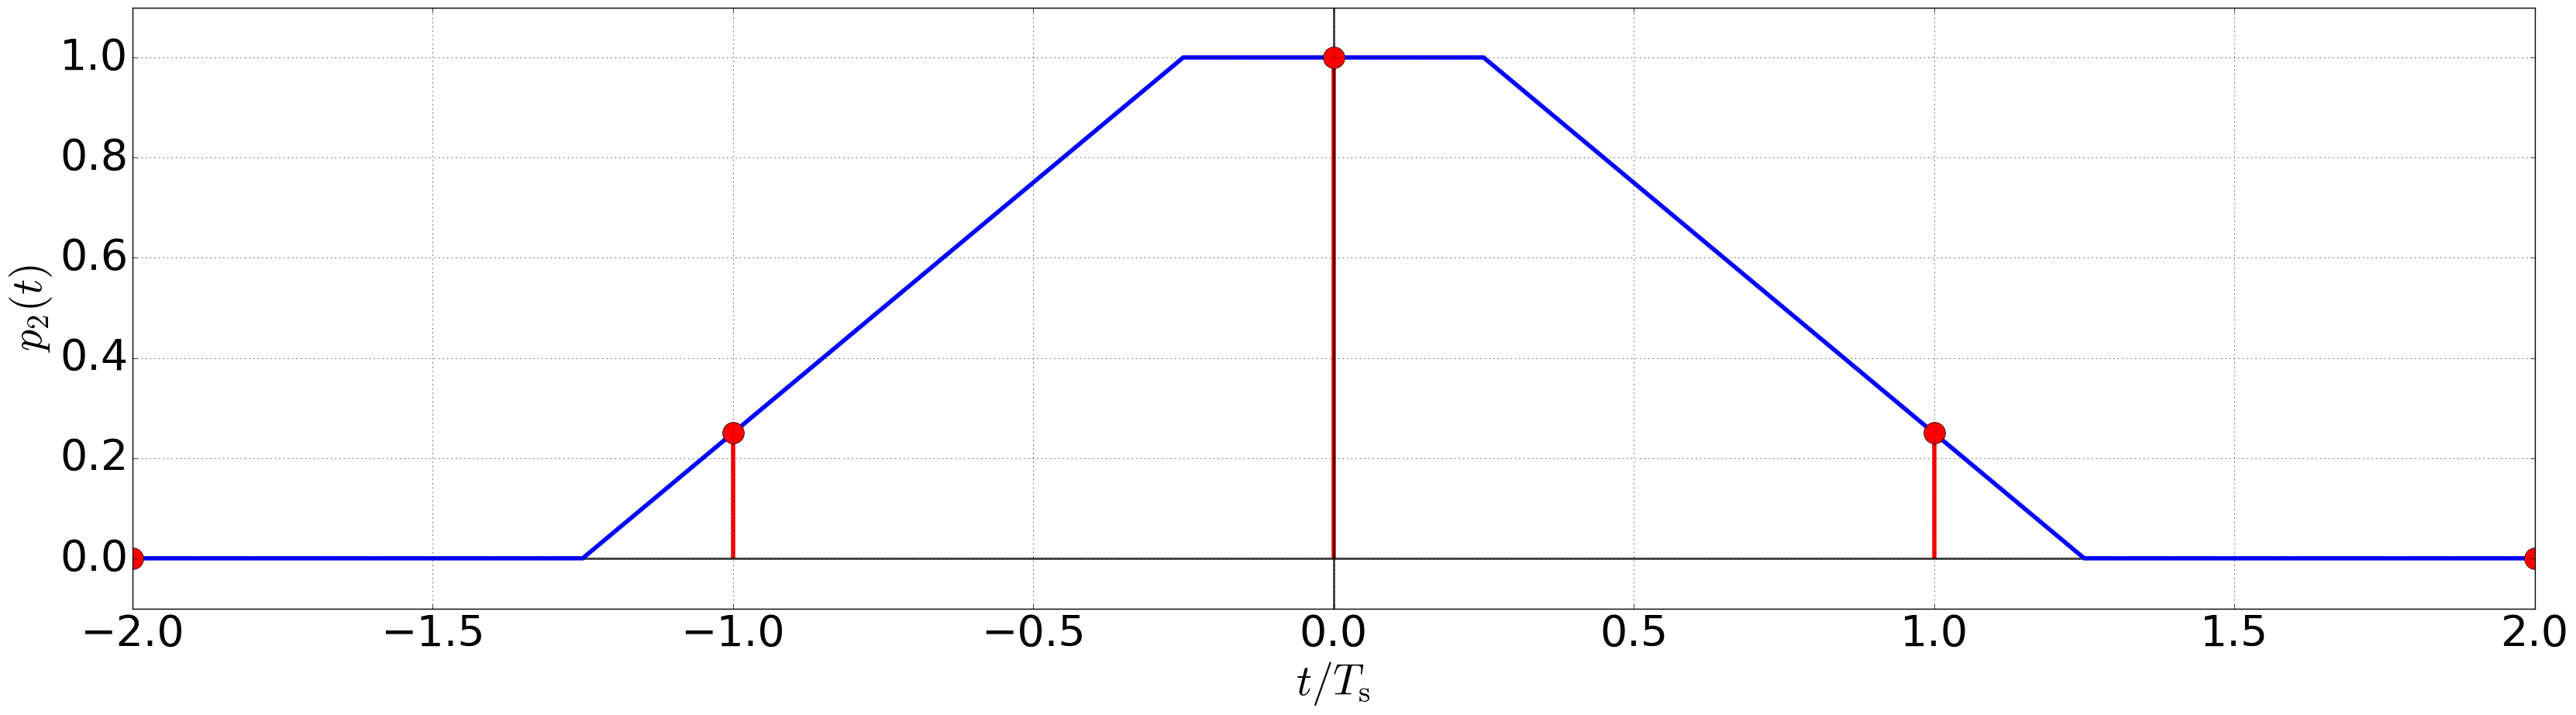

In [22]:
p_2_t = 1/2*tri(t_short + 3*T_s/4, T_s/2) + tri(t_short + T_s/4, T_s/2) + \
        1/2*tri(t_short - 3*T_s/4, T_s/2) + tri(t_short - T_s/4, T_s/2)
plot_complete_pulse(t_short, p_2_t, y_label=r'$p_2(t)$')

Hier gilt $p_1(k T_\mathrm{s}) = \frac{1}{4} \gamma(k+1) + \gamma(k) + \frac{1}{4} \gamma(k-1) \neq C\gamma(k)$.
Das erste Nyquistkriterium ist also nicht erfüllt und es treten ISIs auf.

#### Fall $i=3$:
Wegen $f_3(t) = \delta(t)$ gilt hier:

\begin{align}
    p_3(t) &= g_3(t) \ast f_3(t) \\
    &= \Lambda \left( \frac{t}{T_\mathrm{s}} \right) \ast \delta(t) \\
    &= \Lambda \left( \frac{t}{T_\mathrm{s}} \right) = g_3(t)
\end{align}

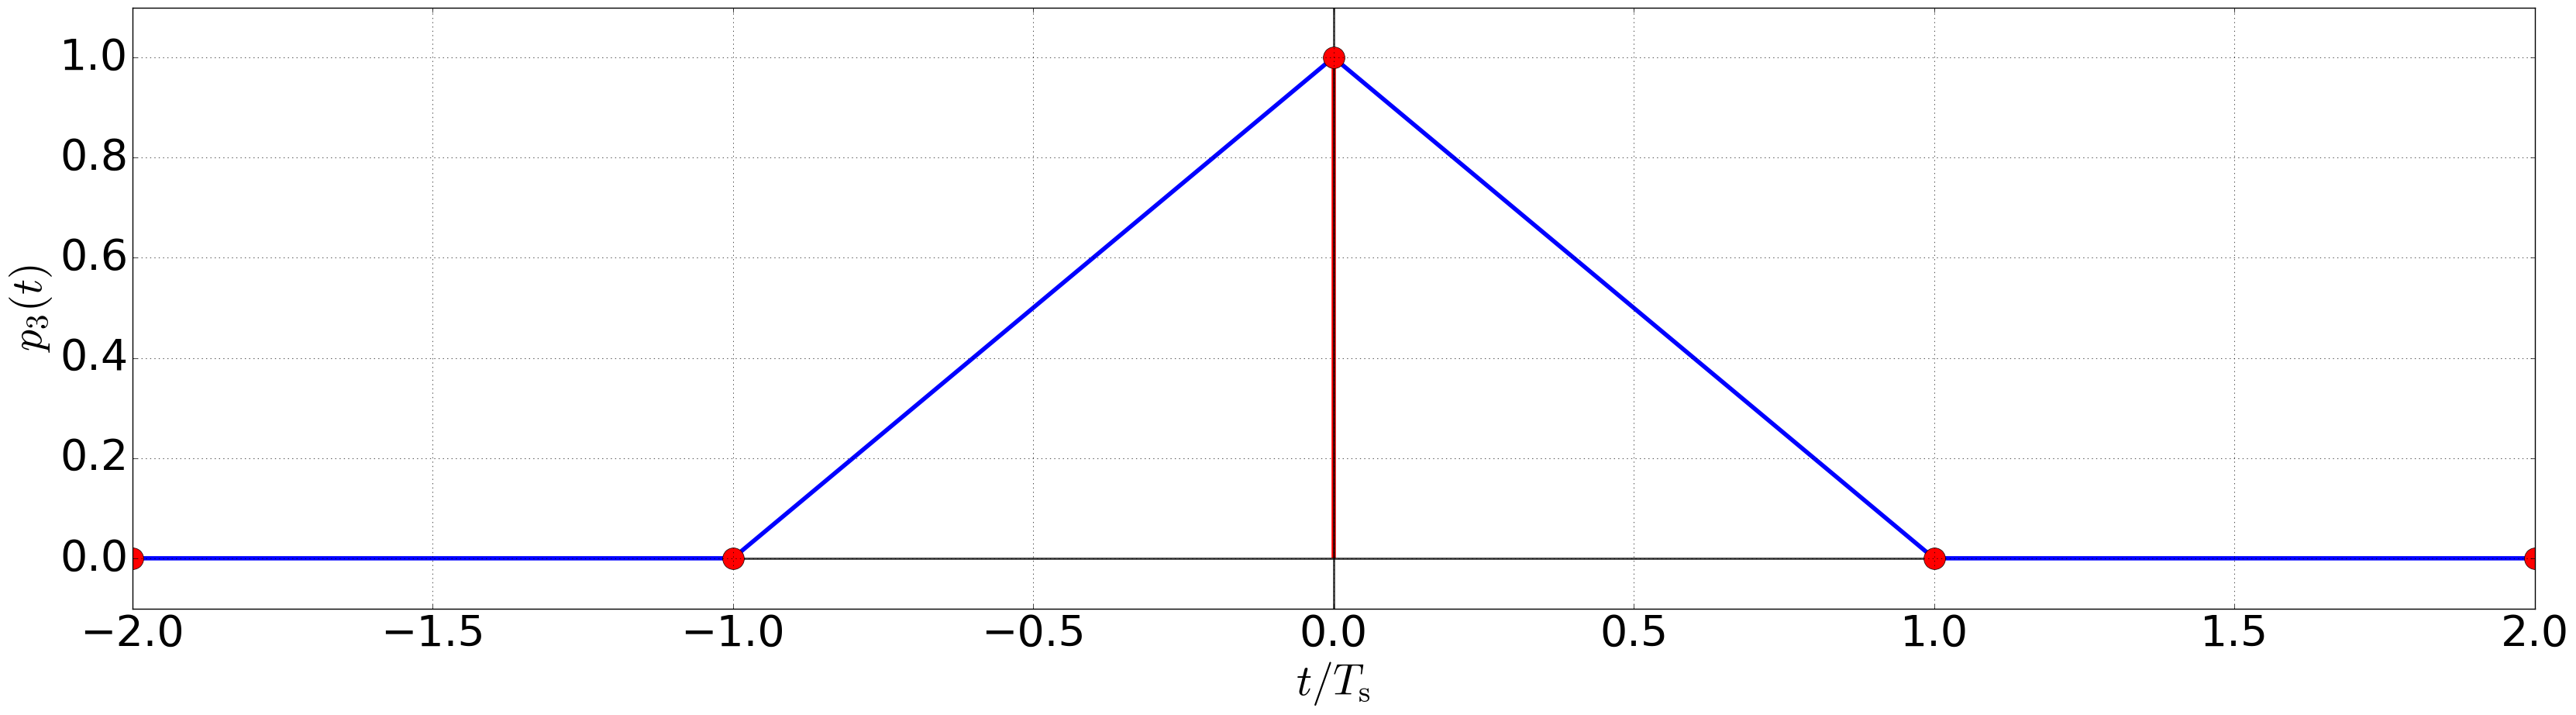

In [23]:
p_3_t = g_3_t.copy()
plot_complete_pulse(t_short, p_3_t, y_label=r'$p_3(t)$')

Leicht abzulesen ist, dass hier $p_3(k T_\mathrm{s}) = \gamma(k)$ gilt, weswegen auch hier das erste Nyquistkriterium erfüllt und die Übertragung ISI-frei ist.

#### 14.3:
Skizzieren sie den Verlauf der Signale $q_i(t)$ für alle Paare

Hier kann man direkt ausnutzen dass bei $n(t) = 0$ gilt:

\begin{align}
    q(t) = \sum_{k = -\infty}^{\infty}A(k) p(t - kT_\mathrm{s})
\end{align}

Es wird also nur das **Gesamtfilter** benötigt.

#### Fall $i=1$:

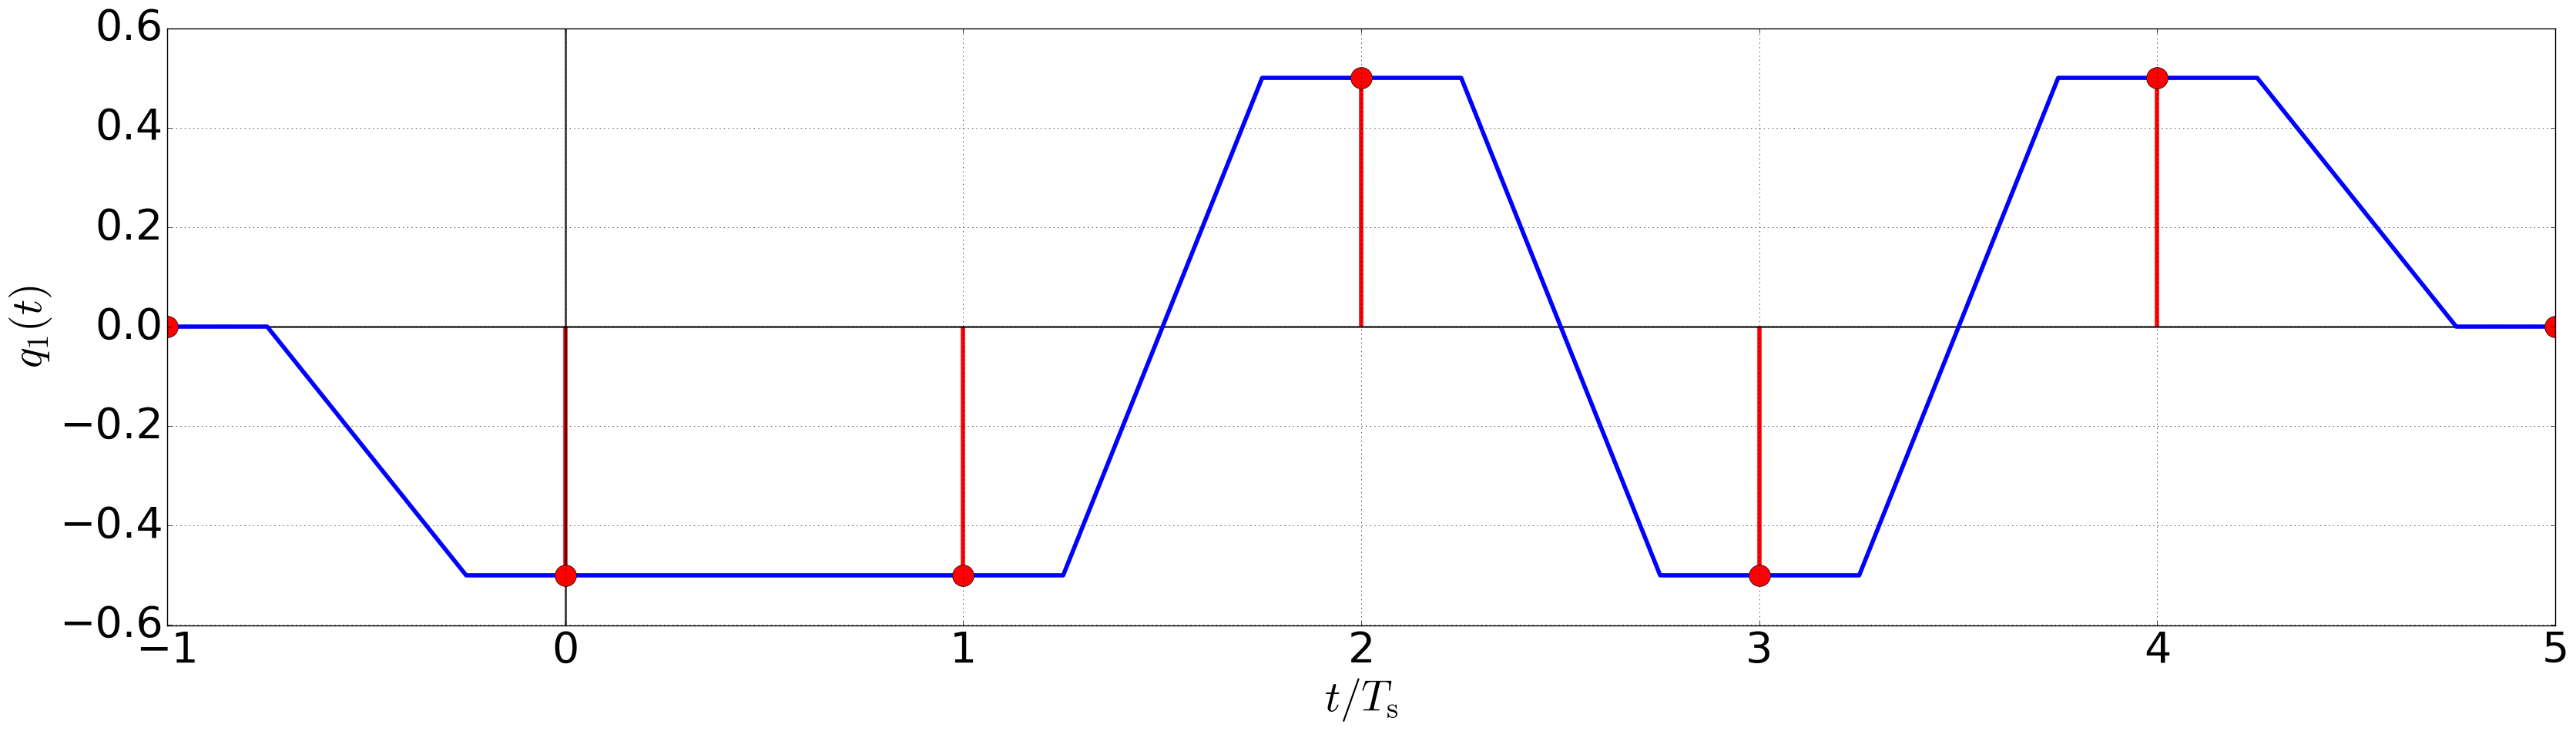

In [24]:
q_1_t = lti_filter(A_t, p_1_t)
plot_decision_signal(t, q_1_t, y_label=r'$q_1(t)$')

#### Fall $i=2$:

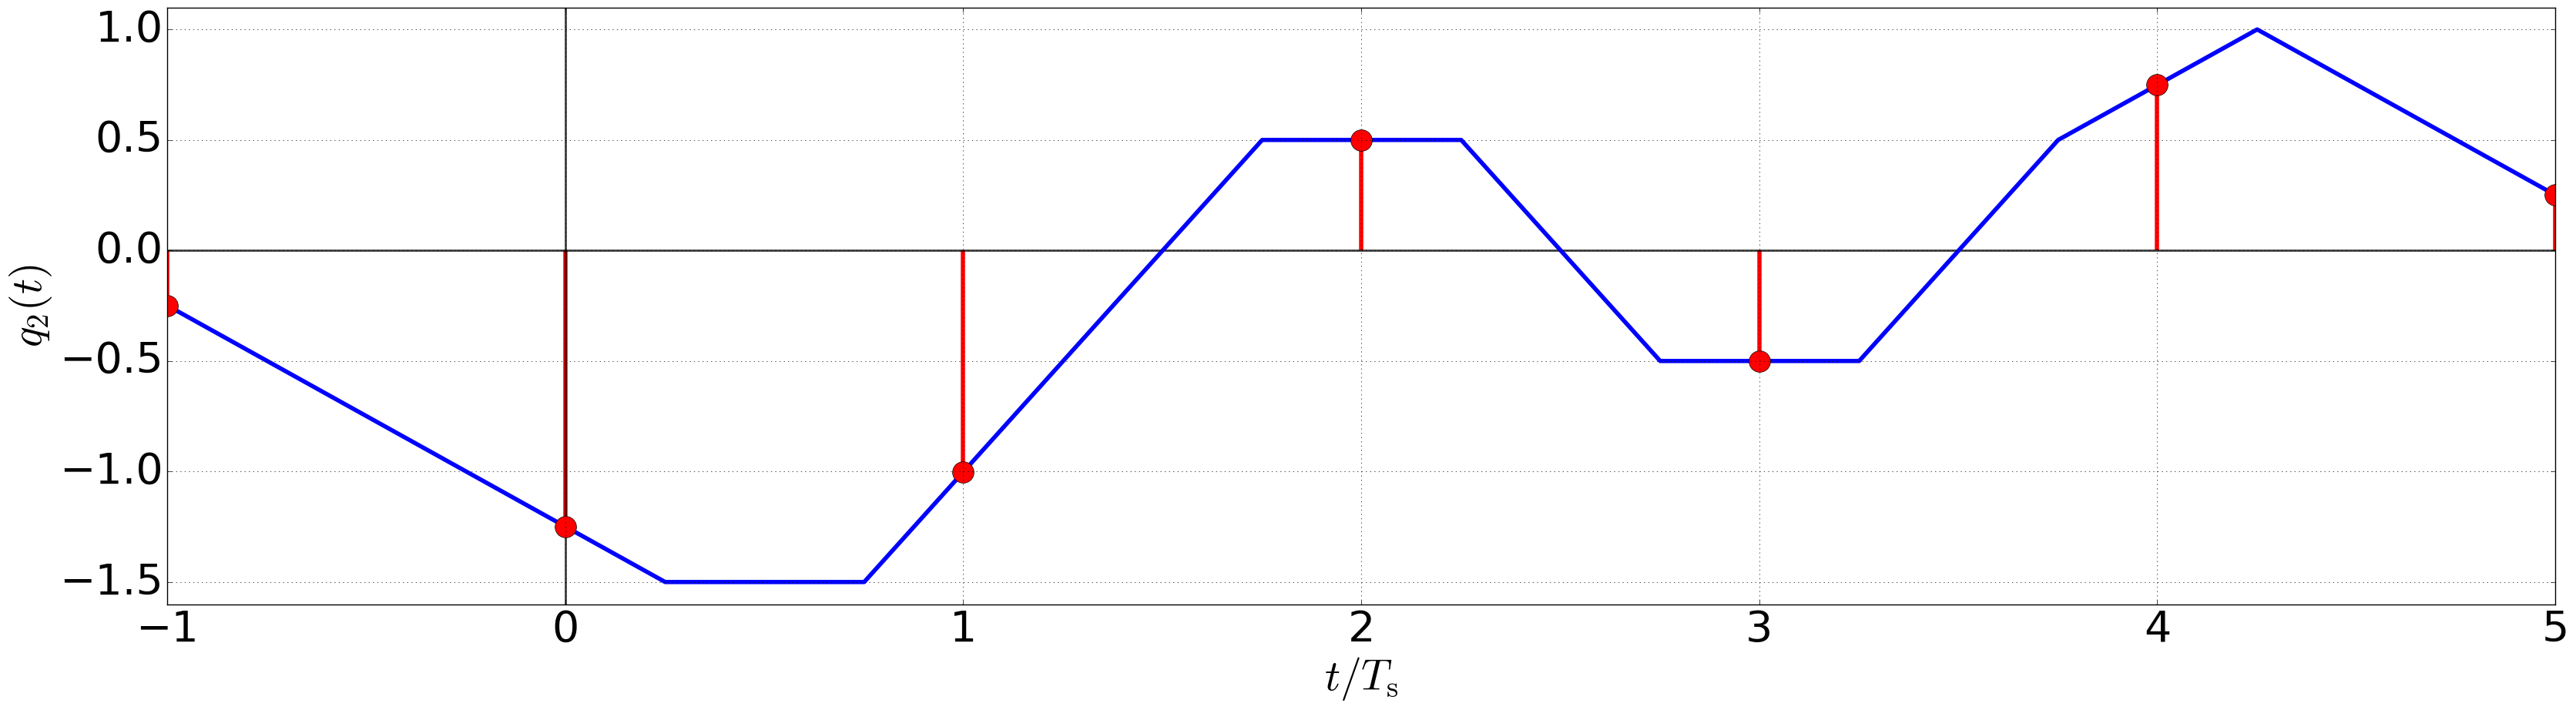

In [25]:
q_2_t = lti_filter(A_t, p_2_t)
plot_decision_signal(t, q_2_t, y_label=r'$q_2(t)$')

#### Fall $i=3$:

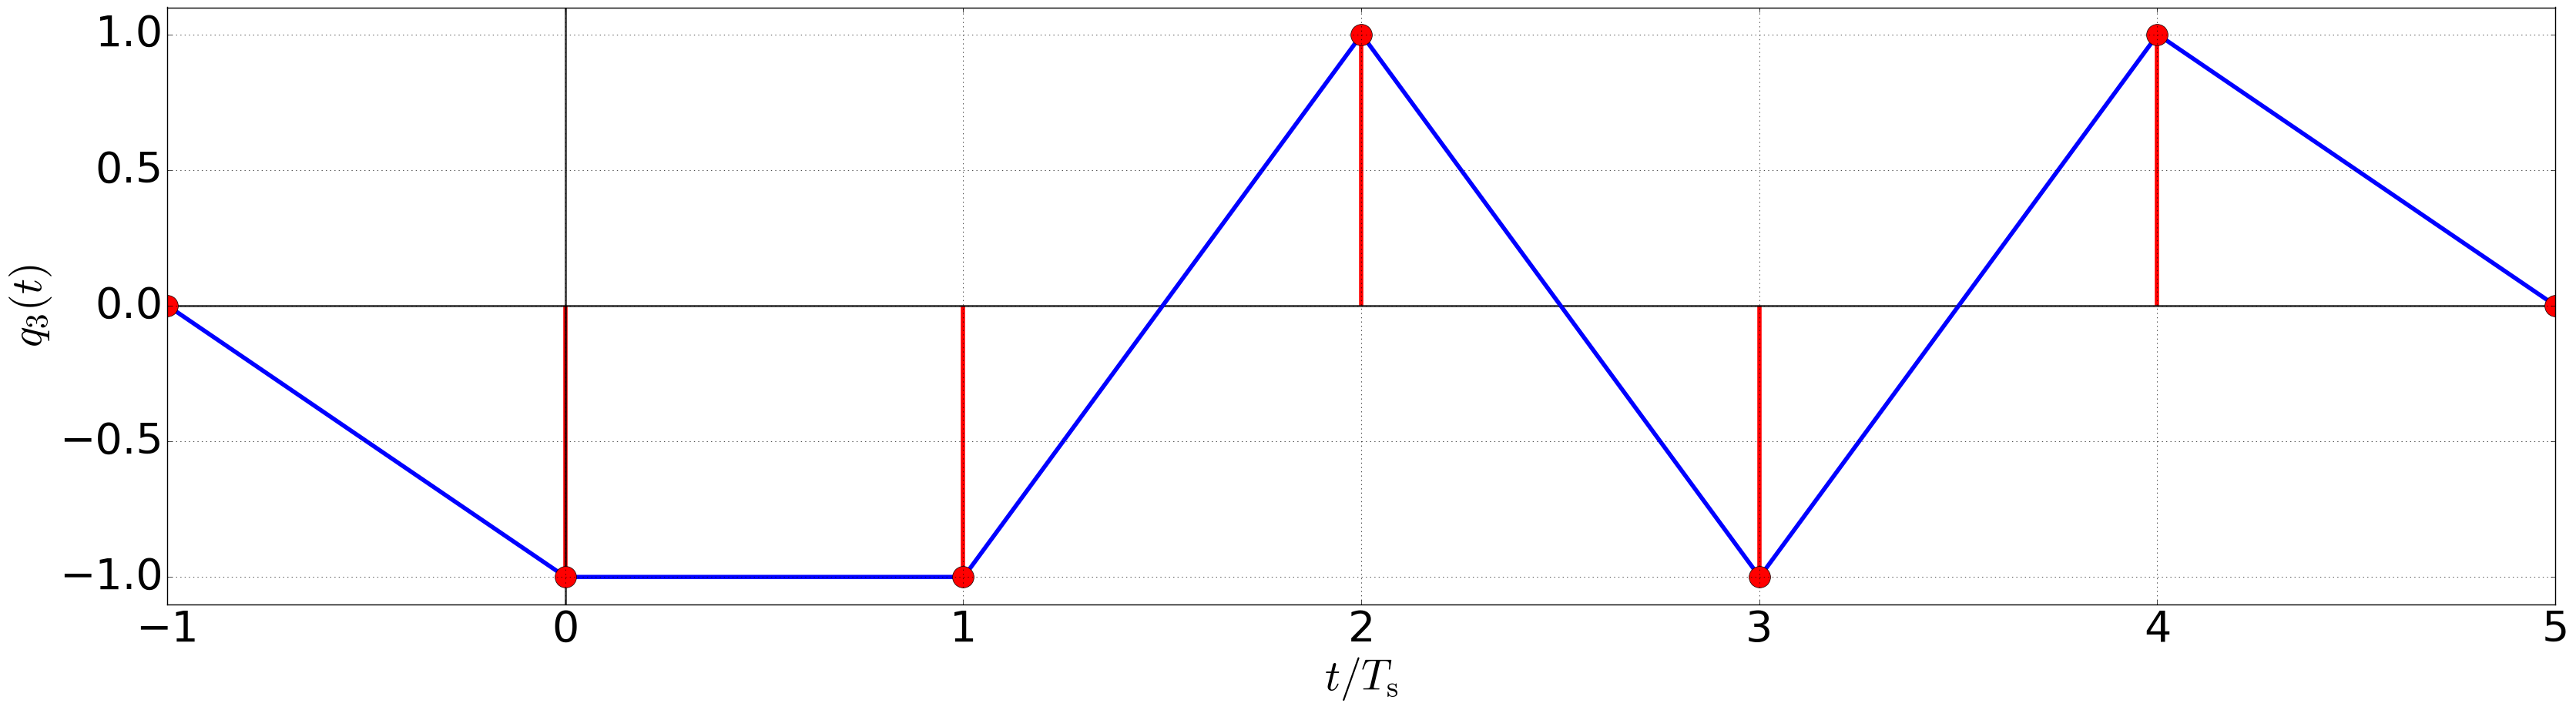

In [26]:
q_3_t = lti_filter(A_t, p_3_t)
plot_decision_signal(t, q_3_t, y_label=r'$q_3(t)$')

### Erläuterung
Auch in den Entscheidungssignalen ist zu sehen, dass die erste und dritte Sequenz frei von Intersymbolinterferenzen sind, während die zweite Sequenz ISIs aufweist.
Das Entscheidungsignal ist dasjenige Signal, das abgetastet wird. Anhand des Abtastwertes wird dann entschieden, welches Symbol gesendet wurde. **Deshalb gilt das erste Nyquistkriterium auch für den Gesamtpuls und nicht nur für den Sendepuls**.

Wenn die Entscheidungsschwelle zu Null gewählt wird, wird zwar auch beim zweiten Signal jedes Symbol richtig erkannt. Jedoch ist das Empfangssignal und damit auch das Entscheidungssignal in der Praxis immer verrauscht (d.h. $(t) \not\equiv 0$). Im praktischen Fall sorgen die ISIs also dafür, dass die Übertragung wesentlich anfälliger für die Störung durch Rauschen sind, was die Fehlerrate stark erhöht.

#### Anderer Weg:
Das Rauschen kann mit der zufälligen Messabweichung in der Messtechnik vergleichen werden, während Intersymbolinterferenzen die Rolle der systematischen Messabweichung einnehmen. Es ist wesentlich schwerer, die zufälligen Abweichungen zu handhaben, wenn nicht einmal im Mittel richtig gemessen/übertragen wird.

## 14.4:
Zeichnen sie jeweils das Augendiagramm für die gegebene Symbolfolge

Um das Augendiagramm zu zeichnen, muss das Entscheidungssignal $q(t)$ verwendet werden.

Augendiagramme sind Oszilloskopbilder, bei denen verschobene, um den Abtastzeitpunkt zentrierte Abschnitte (jeweils mit Zeitargument $t  \in [(k{-}1)\cdot T_\mathrm{s}, (k{+}1)\cdot T_\mathrm{s}]$) des Entscheidungssignals überlagert werden.

Da das Entscheidungssignal bei vernünftig gewählter Gesamtpulsform sein Maximum um den Abtastzeitpunkt hat, entsteht die Form eines Auges. Wichtige Kenngrößen eines Augendiagrammes sind:
- Die horizontale Öffnung, die an einer Stelle in mittlerer Höhe ausgewertet werden sollte und mit der die Robustheit gegenüber Fehlern des Abtastzeitpunktes bewertet werden kann
- Die vertikale Augenöffnung, die über die ganze Höhe zum Abtastzeitpunkt ausgewertet wird und mit der die Robustheit gegenüber Rauschen bewertet werden kann.
- Sichtbare Intersymbolinterferenzen, die häufig zur Verkleinerung der Augenöffnung führen oder im schlimmsten Fall sogar zusätzliche Schnittpunkte zum Abtastzeitpunkt erzeugen.

#### Fall $i=1$:

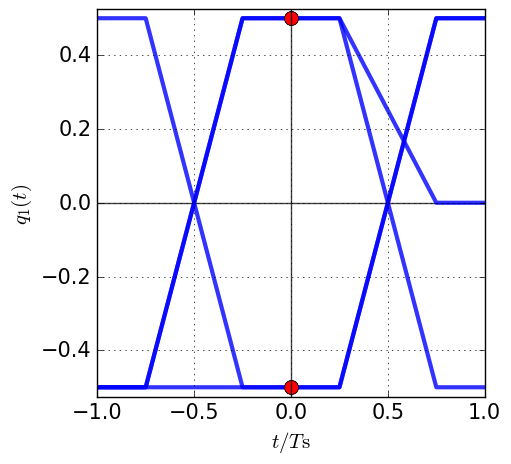

In [27]:
plot_eye_diagram(q_1_t, y_label=r'$q_1(t)$')

Das Auge zum ersten Entscheidungssignal ist sowohl in horizontale als auch vertikale Richtung weit geöffnet und weist deshalb hohe Robustheit sowohl gegenüber Rauschen als auch gegenüber Abtastfehlern auf. Es sind keine Intersymbolinterferenzen zu erkennen. Bis auf den kurzen Abschnitt, der durch das Ausschwingen entstanden ist, ist das Augendiagramm vollständig symmetrisch.

#### Fall $i=2$:

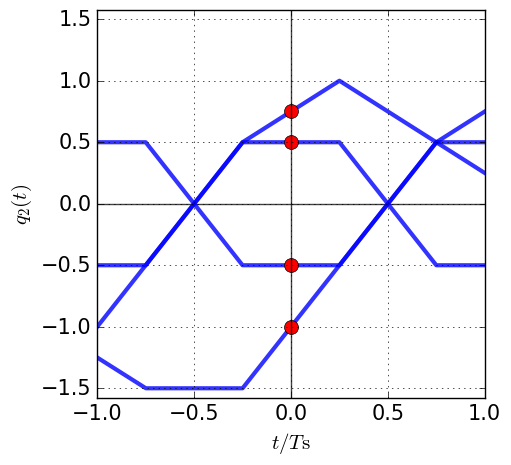

In [28]:
plot_eye_diagram(q_2_t, y_label=r'$q_2(t)$')

Das Auge zum ersten Entscheidungssignal ist zwar in horizontale Richtung weit geöffnet, die sichtbaren Intersymbolinterferenzen sorgen jedoch für eine Verschmälerung der vertikalen Öffnung und zusätzliche Schnittpunkte. Das Diagramm ist zudem durch die kurze Sequenz und die ISIs stark asymmetrisch.

#### Fall $i=3$:

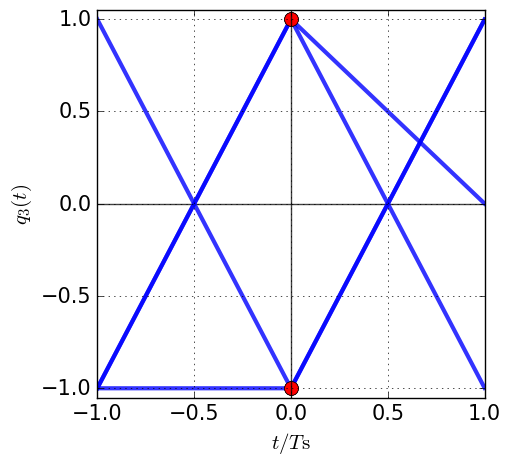

In [29]:
plot_eye_diagram(q_3_t, y_label=r'$q_3(t)$')

Auch für das dritte Entscheidungssignal sind im Augendiagramm keine ISIs zu erkennen. Die Symmetrie ist hoch und die vertikale Augenöffnung ist weit. Die horizontale Öffnung ist hingegen schmaler als bei der ersten Pulssequenz. Hinsichtlich deer Rauschrobustheit ist allerdings zu beachten, dass das Verfahren wegen $f_3(t) = \delta(t)$ in der Praxis nicht funktionieren würde (siehe Kapitel "Matched Filter" in der Vorlesung). Dem könnte durch eine andere Aufteilung des Gesamtpulses begegnet werden, z.B

\begin{align}
    g_3(t) &= \mathrm{rect}\left(\frac{t}{T_\mathrm{s}}\right), \qquad f_3(t) = \frac{1}{T_\mathrm{s}}g_3(-t) \\
    \Rightarrow p_3(t) &= g_3(t) \ast b(t) \ast f_3(t) = \Lambda\left(\frac{t}{T_\mathrm{s}}\right).
\end{align}

## 14.5:
Wenn $p(t)$ das erste Nyquistkriterium erfüllt, erfüllt dann auch $p_\mathrm{BP}(t) = \mathrm{Re}\left\{ p(t)\mathrm{e}^{j \omega_0 t} \right\}$ das Kriterium?

Das erste Nyqustkriterium besagt im Zeitbereich, dass der Gesamtpuls beim Abtasten zu einem (ggf. verschobenen und skalierten) diskreten Einheitsimpuls wird. Dies lässt sich auch im Frequenzbereich ausdrücken

\begin{align}
    \mathcal{F}_d\left\{ p(k T_\mathrm{s}) \right\} = \mathcal{F}_d\left\{ C \gamma(k - K) \right\} = C \mathrm{e}^{-j\omega T_\mathrm{s} K} \\
\end{align}

Im Folgenden wird die Verschiebung ignoriert, d.h. $p(k T_\mathrm{s}) = C \gamma(k)$. Damit gilt zusammen mit der Poisson'schen Summenformel im Frequenzbereich:

\begin{align}
    P\left( \mathrm{e}^{j \omega T_\mathrm{s}} \right) = \frac{1}{T_\mathrm{s}} \sum_{n = -\infty}^{\infty} P \left( j \left( \omega - k \frac{2 \pi}{T_\mathrm{s}} \right) \right) = C
    \overset{!}{=} \mathrm{const.}
\end{align}

Das ist nun für den gegeben Puls zu prüfen. Der Realteiloperator lässt sich ausschreiben:

\begin{align}
    p_\mathrm{BP}(t) = \mathrm{Re}\left\{ p(t)\mathrm{e}^{j \omega_0 t} \right\} = \frac{1}{2} \left( p(t)\mathrm{e}^{j \omega_0 t} + p^\ast(t) \mathrm{e}^{-j \omega_0 t} \right)
\end{align}

Eine Analyse ergibt:
- Aus $p(k T_\mathrm{s}) \overset{!}{=} C \gamma(k)$ folgt $p^\ast(k T_\mathrm{s}) \overset{!}{=} C^\ast\, \gamma(k)$. Wenn also $p(t)$ das Nyquistkriterium erfüllt, erfüllt es auch $p^\ast(t)$.
- Der Modulationssatz besagt, dass die Multiplikation mit der Exponentialschwingung das Spektrum lediglich verschiebt : $\mathcal{F}\left\{ p(t)\mathrm{e}^{j \omega_0 t} \right\} = P\left( j \left( \omega - \omega_0 \right) \right)$. Dieselbe Argumentation führt zu $\mathcal{F}\left\{ p^\ast(t)\mathrm{e}^{-j \omega_0 t} \right\} = P^\ast \left(- j \left( \omega + \omega_0 \right) \right)$
- Wird das erste Nyquistkriterium nun im Frrquenzbereich überprüft, ergibt sich:

\begin{align}
    P_\mathrm{BP}\left( \mathrm{e}^{j \omega T_\mathrm{s}} \right)
    = \frac{1}{2 T_\mathrm{s}} \sum_{n = -\infty}^{\infty} P \left( j \left( \omega - \omega_0 - k \frac{2 \pi}{T_\mathrm{s}} \right) \right)
    + \frac{1}{2 T_\mathrm{s}} \sum_{n = -\infty}^{\infty} P^\ast \left( - j \left( \omega + \omega_0 - k \frac{2 \pi}{T_\mathrm{s}} \right) \right) = \frac{C + C^\ast}{2} = \mathrm{const.}
\end{align}

Das Ergebnis resultiert, weil die Verschiebung eines konstanten Spektrums keine Auswirkung auf das Ergebnis hat.

Erfüllt ein Gesamtfilter das erste Nyquistkriterium im Tiefpassbereich, erfüllt auch das zubehörige Bandpassgesamtfilter das erste Nyquistkriterium.

Gegeben sein nun ein Sendepuls $g_4(t) = \sin\left( \frac{\pi t}{T_\mathrm{s}} \right) \cdot \mathrm{rect}\left( \frac{t}{T_\mathrm{s}} \right)$. Das Sendesignal für die obige Pulsform sieht nun folgendermaßen aus:

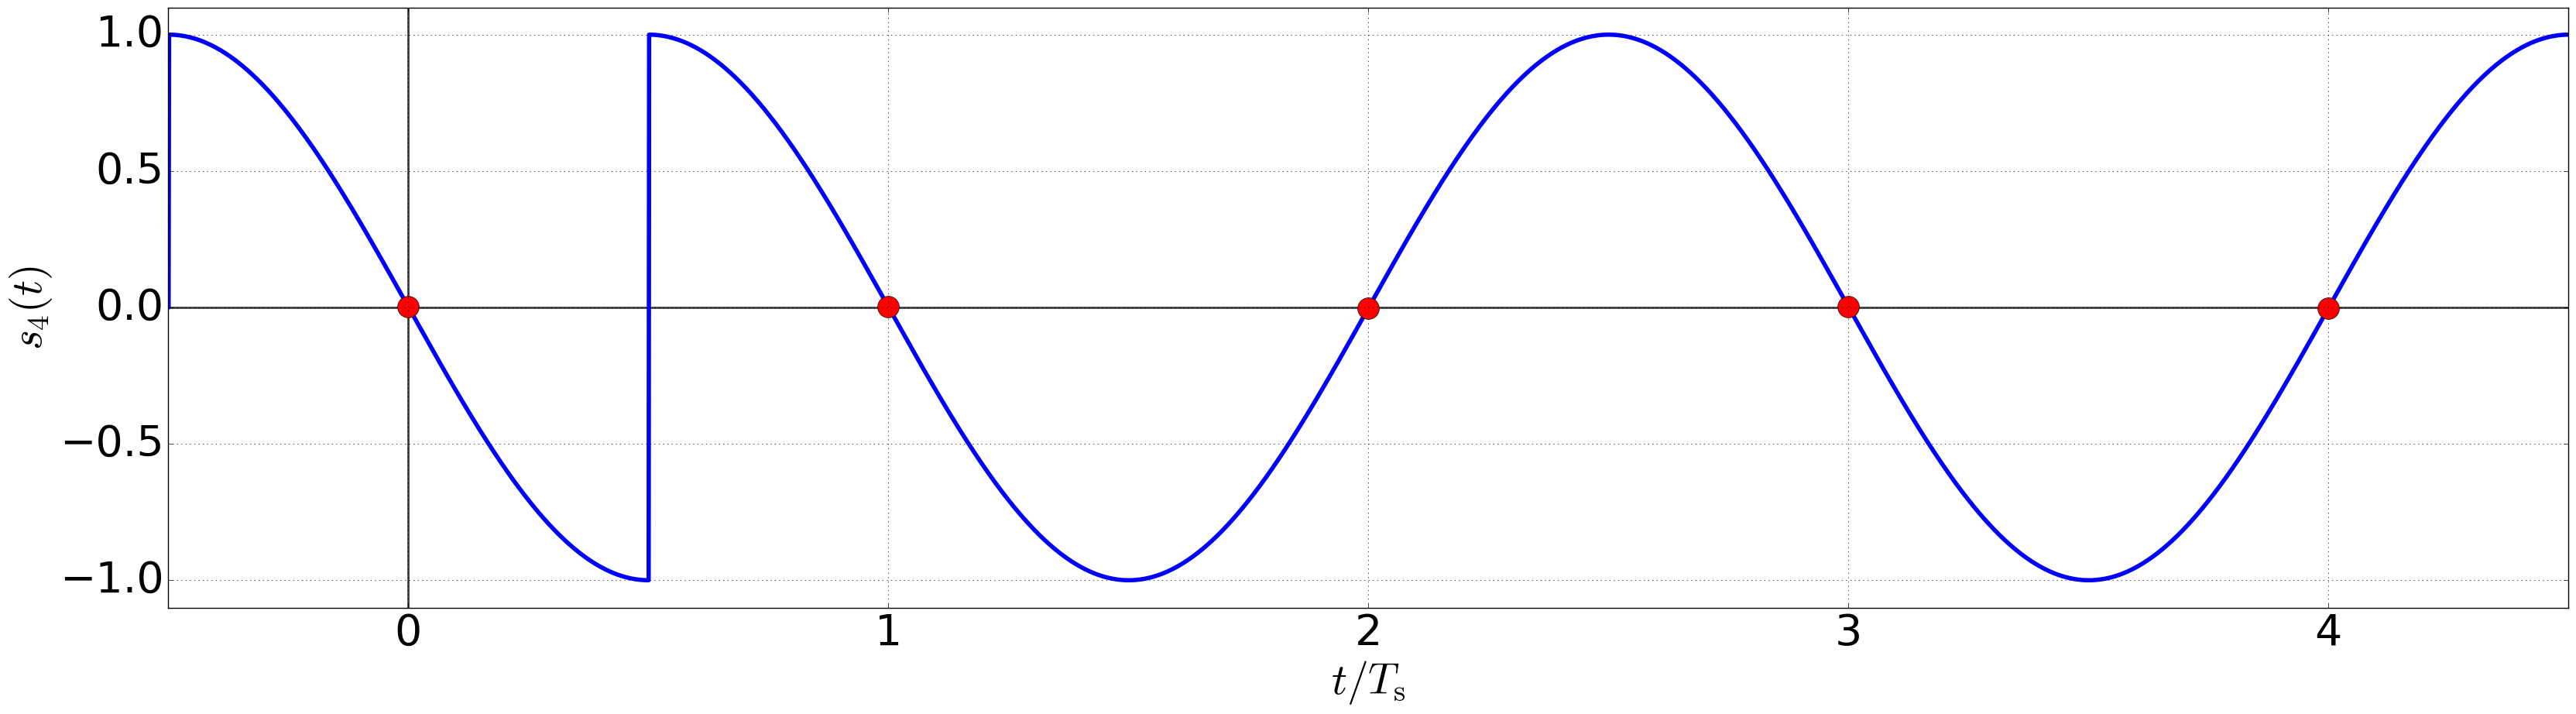

In [30]:
g_4_t = np.sin(np.pi*t_short/T_s)*rect(t_short, T_s)

s_4_t = lti_filter(A_t, g_4_t)
plot_decision_signal(t, s_4_t, y_label=r'$s_4(t)$')
plt.xlim((-0.5, 4.5));

Nun behauptet jemand, dass der Puls nicht für PAM verwendet werden kann, da das dazu gehörende Sendesignal zu allen Abtastzeitpunkten $k T_\mathrm{s}$ Null ist. Das Augendiagramm wäre dementsprechend zu und somit das erste Nyquistkriterium nicht erfüllt.

## 14.6:
Ist diese Behauptung richtig?

Natürlich nicht!
Es wurde bereits einige Male darauf hingewisen, **dass zur Überprüfung des ersten Nyquistkriteriums immer das Gesamtfilter $p(t) = g(t)\ast b(t)\ast f(t)$ betrachtet werden muss**. Im Sendesignal ist jedoch nur die Sendepulsform $g(t)$ sichtbar und die Filterung mit dem Empfangsfilter (und dem Kanal) fehlt noch völlig.
Will man anhand eines Signals Aussagen über die Tauglichkeit einer Pulsform machen, sollte immer das Entscheidungssignal betrachtet werden, denn wegen

\begin{align}
    q(t) = \left( s(t) \ast b(t) + n(t) \right) \ast f(t) = \sum_{k = -\infty}^{\infty} A(k) p(t - k T_\mathrm{s}) + n(t) \ast f(t)
\end{align}

ist darin die Gesamtpulsform enthalten.

Wird beispielsweise $f_4(t) =  \frac{1}{\sqrt{E_g}} \sin\left( -\frac{\pi t}{T_\mathrm{s}} \right) \cdot \mathrm{rect}\left( \frac{t}{T_\mathrm{s}} \right) = \frac{2}{\sqrt{T_\mathrm{s}}} \sin\left( -\frac{\pi t}{T_\mathrm{s}} \right) \cdot \mathrm{rect}\left( \frac{t}{T_\mathrm{s}} \right)$ gewählt, ergibt sich für $p_4(t)$:

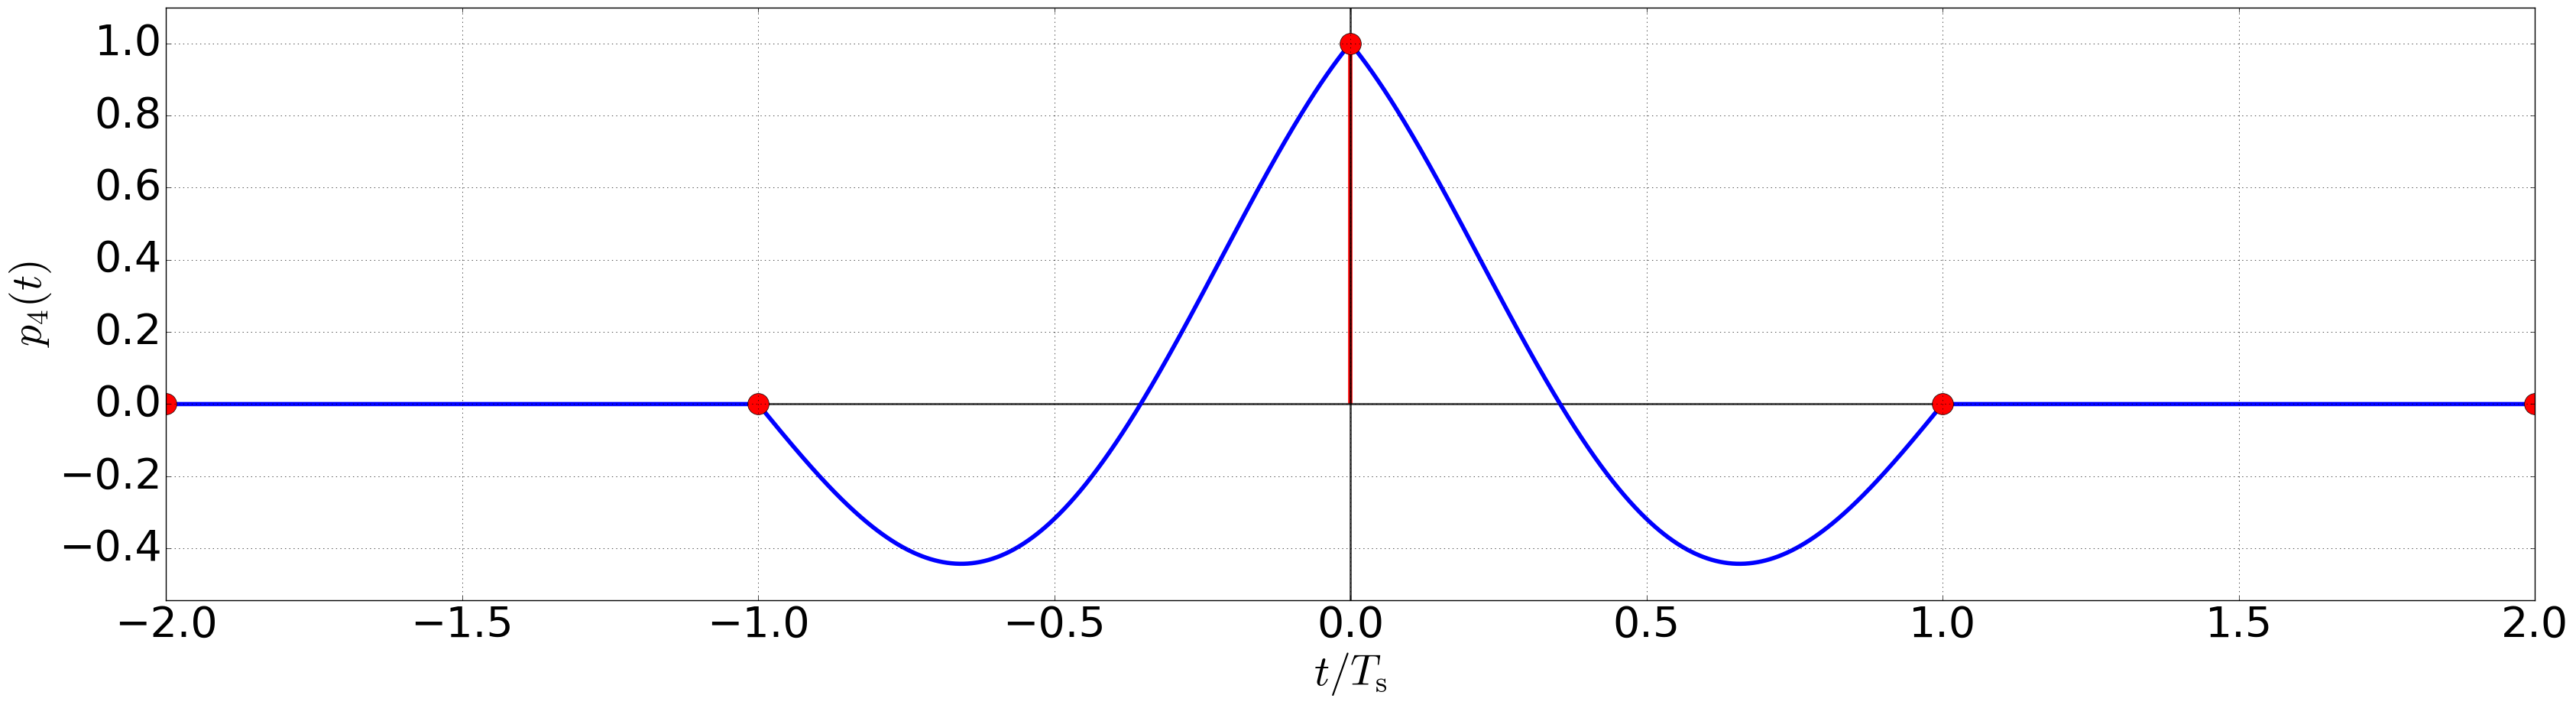

In [31]:
f_4_t = 2/T_s * np.flipud(g_4_t.copy())
p_4_t = lti_filter(g_4_t, f_4_t)
plot_complete_pulse(t_short, p_4_t, y_label=r'$p_4(t)$')

Damit erhält man folgendes Entscheidungssignal $q_4(t)$: 

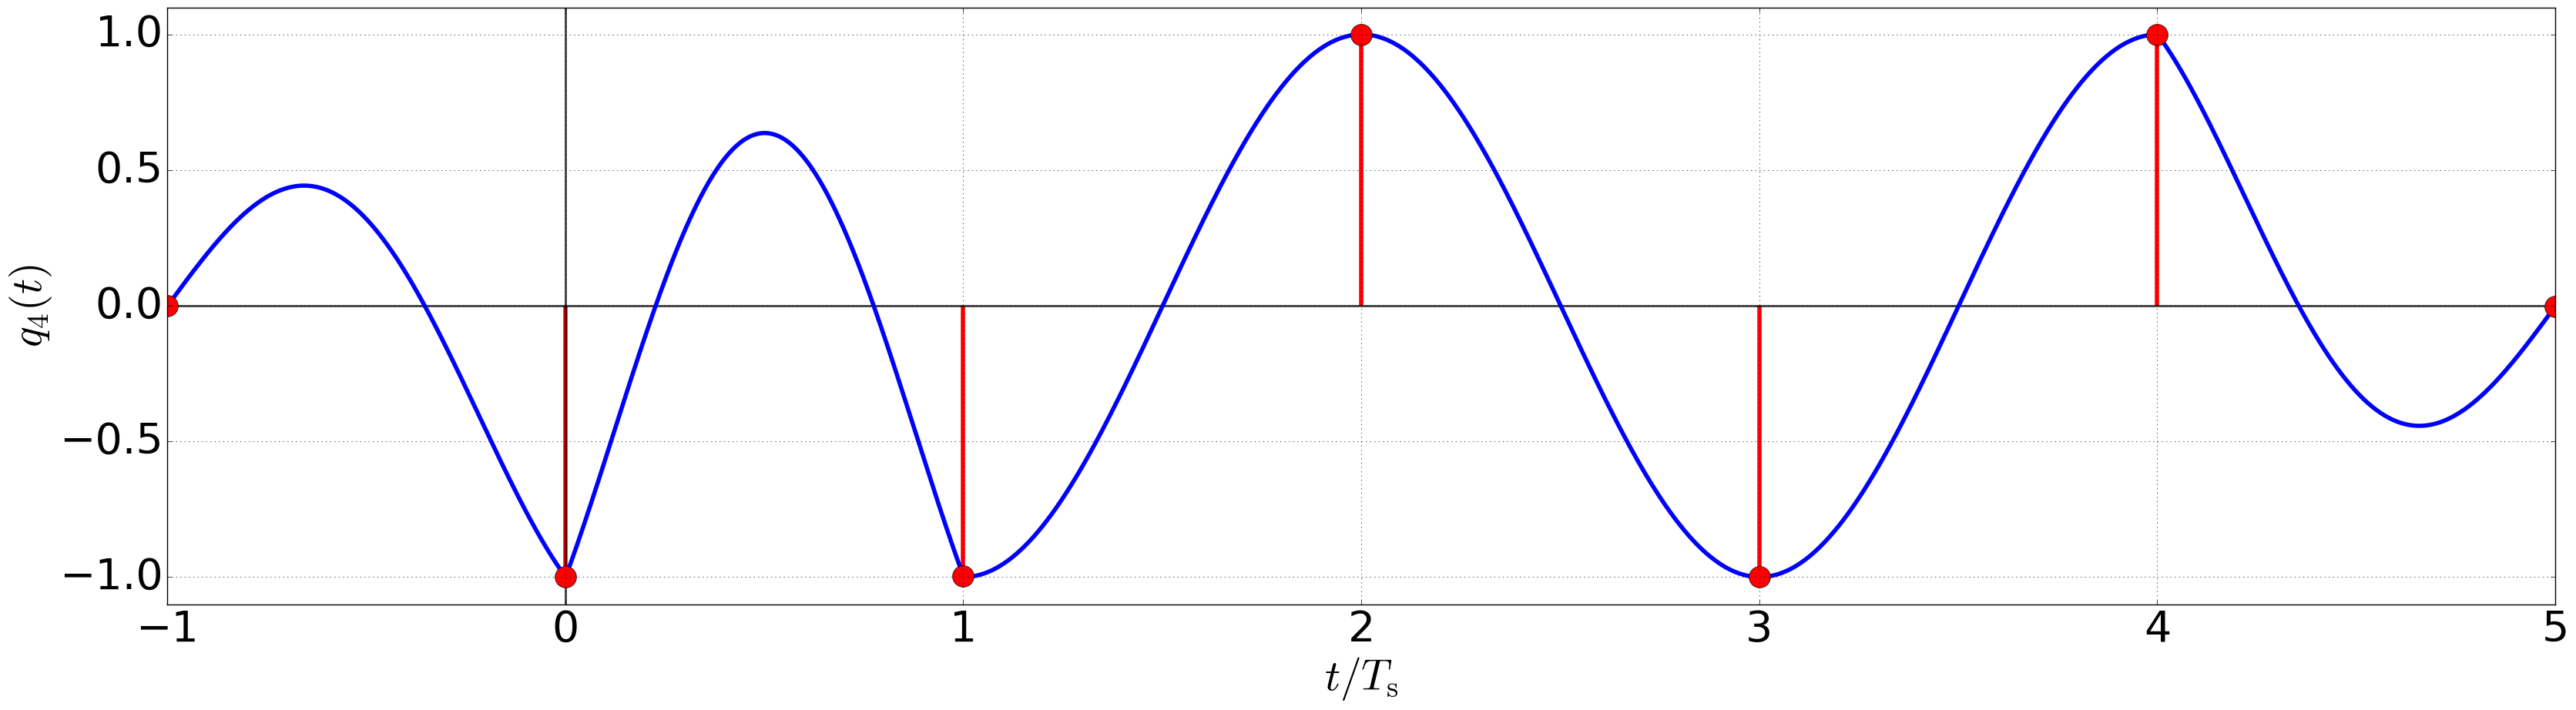

In [32]:
q_4_t = lti_filter(A_t, p_4_t)
plot_decision_signal(t, q_4_t, y_label=r'$q_4(t)$')

Und damit resultiert folgendes Augendiagramm:

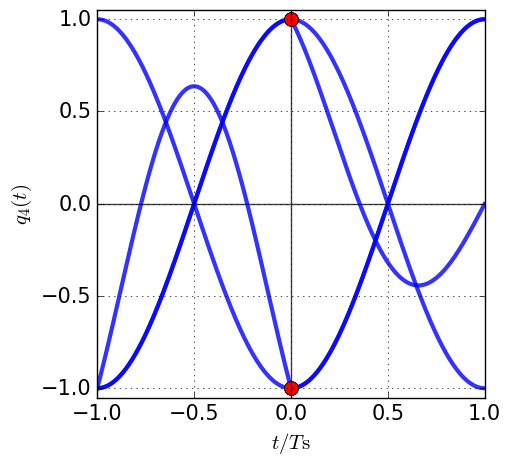

In [33]:
plot_eye_diagram(q_4_t, y_label=r'$q_4(t)$')

An allen drei Diagrammen sollte erkennbar sein, dass die Sendepulsform **zusammen mit dem richtigen Empfangsfilter** eine Gesamtpulsform ergibt, die das erste Nyquistkriterium erfüllt!